# Investigate results of fitting procedure

In [1]:
import sys
sys.path.append("../python/")
#sys.path.append("../python/cluster/")


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
#import bokeh.palettes
import _corner
import imp
imp.reload(_corner)
from _corner import corner
from scipy.stats import gaussian_kde, binned_statistic
import pickle
from matplotlib.offsetbox import AnchoredText
from astropy.constants import R_jup, M_jup, M_sun, L_sun
from scipy.interpolate import interp1d, interp2d
from utils import temperature, heat, temperature_withDM
from scipy.interpolate import griddata
import matplotlib.colors as colors
import utils_plots
imp.reload(utils_plots)
#from utils_plots import plot_FSE_grid_f_gamma_ex1, plot_1Dposterior_ex1, plot_FSE_grid_f_gamma_ex2, plot_1Dposterior_ex1_f, plot_1Dposterior_ex1_gamma
from utils import gNFW_rho
import pickle
from scipy.ndimage import gaussian_filter1d

import imp
import utils_plots
imp.reload(utils_plots)
from utils_plots_up import grid_FSE, grid_FSE_all, grid_coverage_all

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':22})
#rc('text', usetex=True)

## Checking Sven results

In [2]:
!ls /home/mariacst/exoplanets/running/v100/

__pycache__	    exC_4.sh
change_names.py     fitting_Ntimes.py
derivatives.py	    like__N100_sigma0.1_f1.0gamma1.0rs15.0v1
derivatives.pyc     like_test_N100_sigma0.1_f1.0gamma1.0rs15.0v1
emcee_functions.py  mock_generation.py
exC_1.sh	    posterior__N100_sigma0.1_f1.0gamma1.0rs15.0v1
exC_2.sh	    posterior_test_N100_sigma0.1_f1.0gamma1.0rs15.0v1
exC_3.sh	    utils.py


In [3]:
filepath = ("/home/mariacst/exoplanets/running/v100/")
_file    = open(filepath + ("like__N100_sigma0.1_f1.0gamma1.0rs15.0v1"), "rb") 
like1     = pickle.load(_file)
_file    = open(filepath + ("posterior__N100_sigma0.1_f1.0gamma1.0rs15.0v1"), "rb") 
samples1  = pickle.load(_file)

_file    = open(filepath + ("like_test_N100_sigma0.1_f1.0gamma1.0rs15.0v1"), "rb") 
like2     = pickle.load(_file)
_file    = open(filepath + ("posterior_test_N100_sigma0.1_f1.0gamma1.0rs15.0v1"), "rb") 
samples2  = pickle.load(_file)

In [9]:
i=2
#print(np.median(samples1[:, i]), np.median(samples2[:, i]))
print(samples1[:, i][np.argmax(like1)], samples2[:, i][np.argmax(like2)])

1.365932605803891 1.365932605803891


Text(0, 0.5, '-ln($\\mathcal{L}$)')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


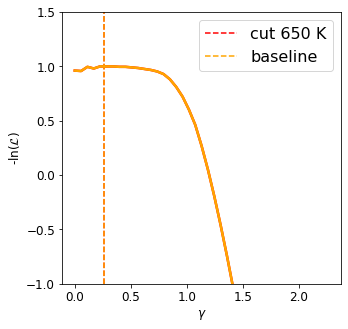

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
     
    
axes.set_xlabel(r"$\gamma$")

bin_n=40
x = binned_statistic(samples1[:, 1], like1, 'max', bins=bin_n)[1] 
y = binned_statistic(samples1[:, 1], like1, 'max', bins=bin_n+1)[0]
y = y - np.max(y[~np.isnan(y)]) + 1
axes.plot(x, y, ls="-", color="r", lw=2.5)
axes.axvline(samples1[:, 1][np.argmax(like1)], color="red", ls="--", label="cut 650 K")

x = binned_statistic(samples2[:, 1], like2, 'max', bins=bin_n)[1] 
y = binned_statistic(samples2[:, 1], like2, 'max', bins=bin_n+1)[0]
y = y - np.max(y[~np.isnan(y)]) + 1
axes.plot(x, y, ls="-", color="orange", lw=2.5)
axes.axvline(samples2[:, 1][np.argmax(like2)], color="orange", ls="--", label="baseline")

axes.set_ylim(-1, 1.5)
axes.legend(fontsize=16)

axes.set_ylabel(r"-ln($\mathcal{L}$)")

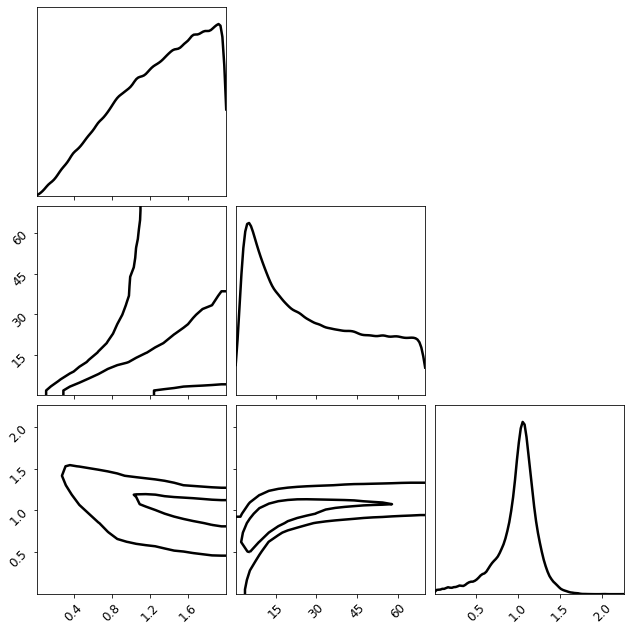

In [12]:
smooth=0.8

fig, axes = corner(np.array([samples1[:, 0], samples1[:, 2], samples1[:, 1]]).T, 
                   levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="k")
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], np.array([samples1[:, 0], samples1[:, 2], samples1[:, 1]])):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5)

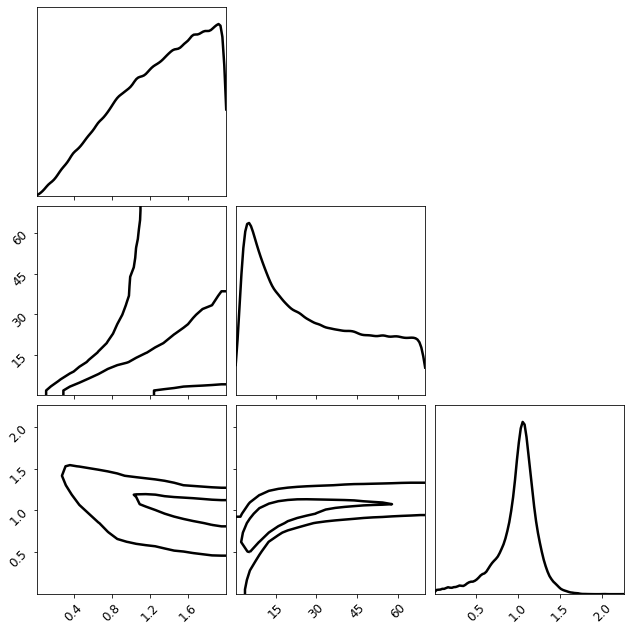

In [13]:
smooth=0.8

fig, axes = corner(np.array([samples2[:, 0], samples2[:, 2], samples2[:, 1]]).T, 
                   levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="k")
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], np.array([samples2[:, 0], samples2[:, 2], samples2[:, 1]])):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5)

**Study the effect of samples discreteness in likelihood computation**

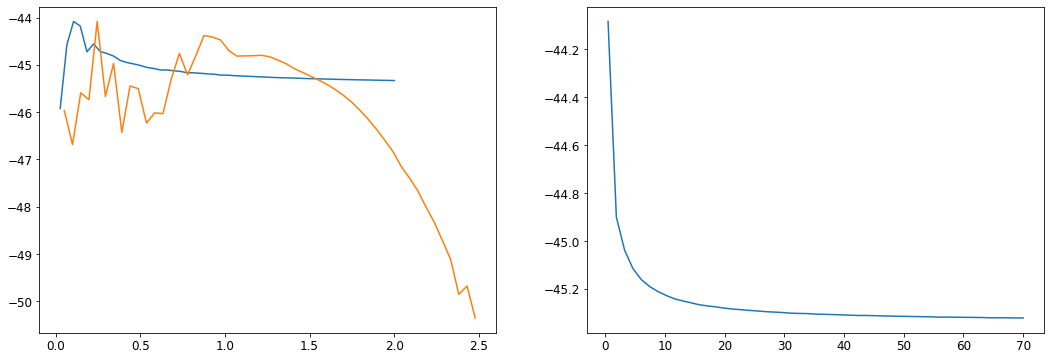

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

x = binned_statistic(samples[:, 0], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 0], like, 'max', bins=bin_n+1)[0]

ax[0].plot(x, y)

x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]

ax[0].plot(x, y)

x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]

ax[1].plot(x, y)

## Study the effect of the priors

**Uniform priors but gamma only up to 2**

0.010041561828150844 69.99769141296726    -10.151324188438025 1.0
0.0012168436249384573 1.999996080433541    0.429599938988531 1.0
0.01000023808390152 0.8488012664201676    -19.88974761659489 1.0


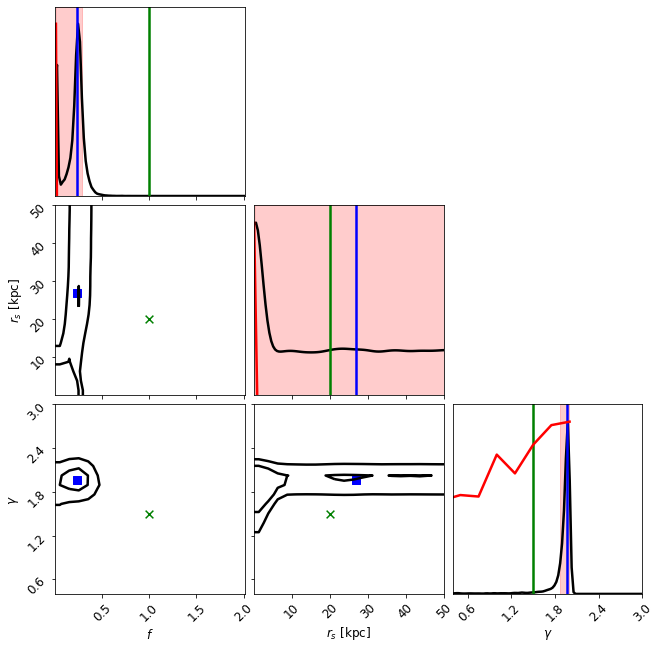

In [109]:
nBDs     = 1000 ; sigma= 0.3
f        = 1.; gamma = 1.5; rs = 20.
nwalkers = 50; steps = 4000

filepath = ("/home/mariacst/exoplanets/running/checks/")
_file    = open(filepath + ("like_N%i_sigma%.1f_f1.0gamma%.1frs%.1f_nwalkers%i_steps%i" 
                            %(nBDs, sigma, gamma, rs, nwalkers, steps)), "rb") 
like     = pickle.load(_file)
_file    = open(filepath + ("posterior_N%i_sigma%.1f_f1.0gamma%.1frs%.1f_nwalkers%i_steps%i" 
                            %(nBDs, sigma, gamma, rs, nwalkers, steps)), "rb") 
samples  = pickle.load(_file)
smooth=1.
fig, axes = corner(np.array([samples[:, 0], samples[:, 2], samples[:, 1]]).T, 
                   levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="k",
                   range=[(0.001, 2.01), (0., 50.), (0.4, 3.)])
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], np.array([samples[:, 0], samples[:, 2], samples[:, 1]])):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5)      
    
axes[0, 0].axvline(1., color="g", ls="-", lw=2.5); axes[0, 0].axvline(np.median(samples[:, 0]), color="b", ls="-", lw=2.5)
axes[1, 1].axvline(rs, color="g", ls="-", lw=2.5); axes[1, 1].axvline(np.median(samples[:, 2]), color="b", ls="-", lw=2.5)
axes[2, 2].axvline(gamma, color="g", ls="-", lw=2.5); axes[2, 2].axvline(np.median(samples[:, 1]), color="b", ls="-", lw=2.5)
axes[1, 0].scatter(f, rs, marker="x", color="g", s=60); axes[1, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 2]), marker="s", color="b", s=60)
axes[2, 0].scatter(f, gamma, marker="x", color="g", s=60); axes[2, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 1]), marker="s", color="b", s=60)
axes[2, 1].scatter(rs, gamma, marker="x", color="g", s=60); axes[2, 1].scatter(np.median(samples[:, 2]), np.median(samples[:, 1]), marker="s", color="b", s=60)

axes[0, 0].axvspan(np.percentile(samples[:, 0], 16), np.percentile(samples[:, 0], 84), color="red", alpha=0.2)
axes[1, 1].axvspan(np.percentile(samples[:, 2], 16), np.percentile(samples[:, 2], 84), color="red", alpha=0.2)
axes[2, 2].axvspan(np.percentile(samples[:, 1], 16), np.percentile(samples[:, 1], 84), color="red", alpha=0.2)

axes[1, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$\gamma$")
axes[2, 1].set_xlabel(r"$r_s$ [kpc]")
axes[2, 2].set_xlabel(r"$\gamma$")

bin_n=8
x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[1, 1].plot(x, y, ls="-", color="r", lw=2.5)

x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[2, 2].plot(x, y, ls="-", color="r", lw=2.5)

x = binned_statistic(samples[:, 0], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 0], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[0, 0].plot(x, y, ls="-", color="r", lw=2.5)

#fig.savefig("fixedT100K_posterior_nBDs100_sigma0.3_gamma1.5_rs20.pdf", bbox_inches="tight")

**Uniform priors - standard case**

0.013944677081084933 69.99612116926369    0.9706455697606202 1.0
0.7619874765387677 2.9999468513201073    -8.022127187391362 1.0
0.010001752611724812 1.9976880204743042    -5.500321077305813 1.0


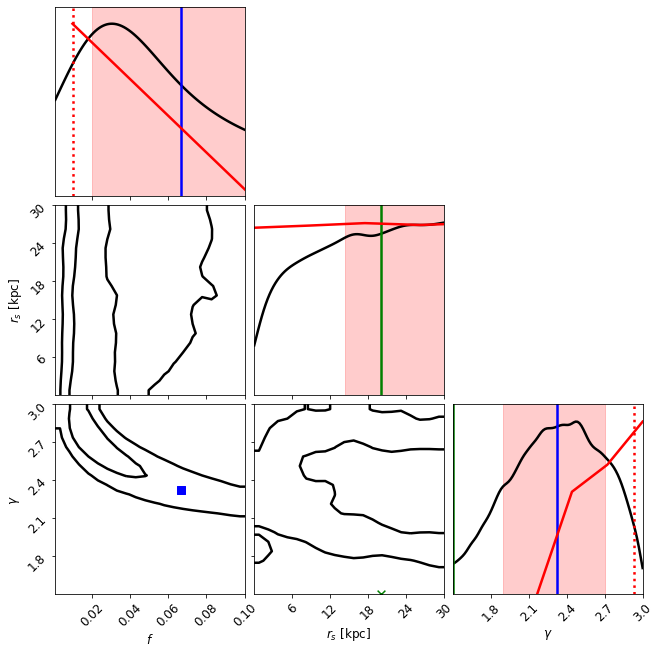

In [35]:
nBDs     = 100 ; sigma= 0.3
f        = 1.; gamma    = 1.5; rs = 20.

filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/check/N100sigma0.3/")
_file    = open(filepath + ("like_checkT_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv31" %(nBDs, sigma, gamma, rs)), "rb") 
like     = pickle.load(_file)
filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/check/N100sigma0.3/")
_file    = open(filepath + ("posterior_checkT_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv31" %(nBDs, sigma, gamma, rs)), "rb") 
samples  = pickle.load(_file)
smooth=1.
fig, axes = corner(np.array([samples[:, 0], samples[:, 2], samples[:, 1]]).T, 
                   levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="k",
                   range=[(0.001, 0.1), (0., 30.), (1.5, 3.)])
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], np.array([samples[:, 0], samples[:, 2], samples[:, 1]])):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5)      
    
axes[0, 0].axvline(1., color="g", ls="-", lw=2.5); axes[0, 0].axvline(np.median(samples[:, 0]), color="b", ls="-", lw=2.5)
axes[1, 1].axvline(rs, color="g", ls="-", lw=2.5); axes[1, 1].axvline(np.median(samples[:, 2]), color="b", ls="-", lw=2.5)
axes[2, 2].axvline(gamma, color="g", ls="-", lw=2.5); axes[2, 2].axvline(np.median(samples[:, 1]), color="b", ls="-", lw=2.5)
axes[1, 0].scatter(f, rs, marker="x", color="g", s=60); axes[1, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 2]), marker="s", color="b", s=60)
axes[2, 0].scatter(f, gamma, marker="x", color="g", s=60); axes[2, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 1]), marker="s", color="b", s=60)
axes[2, 1].scatter(rs, gamma, marker="x", color="g", s=60); axes[2, 1].scatter(np.median(samples[:, 2]), np.median(samples[:, 1]), marker="s", color="b", s=60)

axes[0, 0].axvspan(np.percentile(samples[:, 0], 16), np.percentile(samples[:, 0], 84), color="red", alpha=0.2)
axes[1, 1].axvspan(np.percentile(samples[:, 2], 16), np.percentile(samples[:, 2], 84), color="red", alpha=0.2)
axes[2, 2].axvspan(np.percentile(samples[:, 1], 16), np.percentile(samples[:, 1], 84), color="red", alpha=0.2)

axes[1, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$\gamma$")
axes[2, 1].set_xlabel(r"$r_s$ [kpc]")
axes[2, 2].set_xlabel(r"$\gamma$")

bin_n=8
x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[1, 1].plot(x, y, ls="-", color="r", lw=2.5)

x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[2, 2].plot(x, y, ls="-", color="r", lw=2.5)

x = binned_statistic(samples[:, 0], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 0], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[0, 0].plot(x, y, ls="-", color="r", lw=2.5)

0.029616035049505385 69.99791928903073    0.8928534655125873 1.0
1.5489170474165623 2.9995995194680196    -21.027082994048044 1.0
0.010000205691290507 0.9278851338477809    -24.360137372069175 1.0


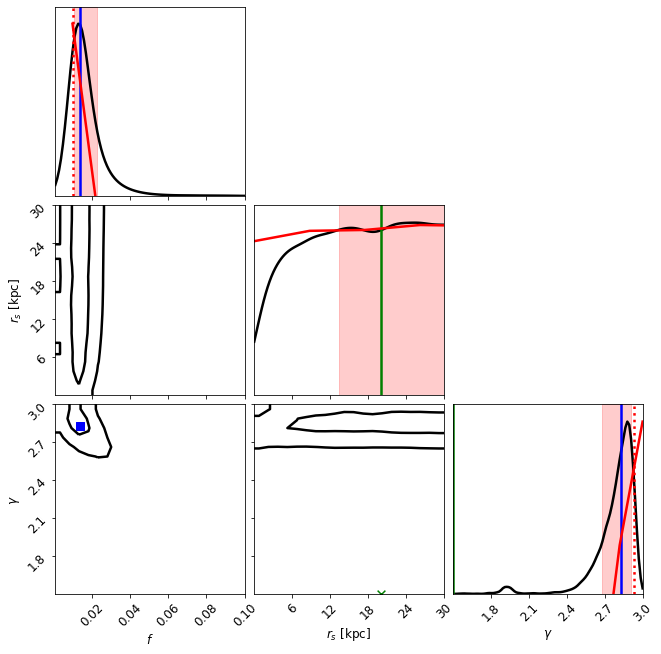

In [27]:
nBDs     = 1000 ; sigma= 0.3
f        = 1.; gamma    = 1.5; rs = 20.
nwalkers=50; steps=4000

filepath = ("/home/mariacst/exoplanets/running/checks/results/")
_file    = open(filepath + ("like_N%i_sigma%.1f_f1.0gamma%.1frs%.1f_nwalkers%i_steps%i" 
                            %(nBDs, sigma, gamma, rs, nwalkers, steps)), "rb") 
like     = pickle.load(_file)
_file    = open(filepath + ("posterior_N%i_sigma%.1f_f1.0gamma%.1frs%.1f_nwalkers%i_steps%i" 
                            %(nBDs, sigma, gamma, rs, nwalkers, steps)), "rb") 
samples  = pickle.load(_file)
smooth=1.
fig, axes = corner(np.array([samples[:, 0], samples[:, 2], samples[:, 1]]).T, 
                   levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="k",
                   range=[(0.001, 0.1), (0., 30.), (1.5, 3.)])
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], np.array([samples[:, 0], samples[:, 2], samples[:, 1]])):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5)      
    
axes[0, 0].axvline(1., color="g", ls="-", lw=2.5); axes[0, 0].axvline(np.median(samples[:, 0]), color="b", ls="-", lw=2.5)
axes[1, 1].axvline(rs, color="g", ls="-", lw=2.5); axes[1, 1].axvline(np.median(samples[:, 2]), color="b", ls="-", lw=2.5)
axes[2, 2].axvline(gamma, color="g", ls="-", lw=2.5); axes[2, 2].axvline(np.median(samples[:, 1]), color="b", ls="-", lw=2.5)
axes[1, 0].scatter(f, rs, marker="x", color="g", s=60); axes[1, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 2]), marker="s", color="b", s=60)
axes[2, 0].scatter(f, gamma, marker="x", color="g", s=60); axes[2, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 1]), marker="s", color="b", s=60)
axes[2, 1].scatter(rs, gamma, marker="x", color="g", s=60); axes[2, 1].scatter(np.median(samples[:, 2]), np.median(samples[:, 1]), marker="s", color="b", s=60)

axes[0, 0].axvspan(np.percentile(samples[:, 0], 16), np.percentile(samples[:, 0], 84), color="red", alpha=0.2)
axes[1, 1].axvspan(np.percentile(samples[:, 2], 16), np.percentile(samples[:, 2], 84), color="red", alpha=0.2)
axes[2, 2].axvspan(np.percentile(samples[:, 1], 16), np.percentile(samples[:, 1], 84), color="red", alpha=0.2)

axes[1, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$\gamma$")
axes[2, 1].set_xlabel(r"$r_s$ [kpc]")
axes[2, 2].set_xlabel(r"$\gamma$")

ML = samples[np.argmax(like)]
axes[0, 0].axvline(ML[0], ls=":", lw=2.5, color="r"); 
axes[1, 1].axvline(ML[2], ls=":", lw=2.5, color="r");
axes[2, 2].axvline(ML[1], ls=":", lw=2.5, color="r");

bin_n=8
x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[1, 1].plot(x, y, ls="-", color="r", lw=2.5)

x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[2, 2].plot(x, y, ls="-", color="r", lw=2.5)

x = binned_statistic(samples[:, 0], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 0], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[0, 0].plot(x, y, ls="-", color="r", lw=2.5)

#fig.savefig("fixedT100K_posterior_nBDs100_sigma0.3_gamma1.5_rs20.pdf", bbox_inches="tight")

**Log prior in rs and f**

In [2]:
nBDs     = 1000 ; sigma= 0.3
f        = 1.; gamma    = 1.5; rs = 20.

filepath = ("/home/mariacst/exoplanets/running/checks/")
_file    = open(filepath + ("like_N%i_sigma%.1f_f1.0gamma%.1frs%.1f_log" 
                            %(nBDs, sigma, gamma, rs)), "rb") 
like     = pickle.load(_file)
_file    = open(filepath + ("posterior_N%i_sigma%.1f_f1.0gamma%.1frs%.1f_log" 
                            %(nBDs, sigma, gamma, rs)), "rb") 
samples  = pickle.load(_file)
smooth=1.
fig, axes = corner(np.array([np.power(10, samples[:, 0]), samples[:, 2], np.power(10, samples[:, 1])]).T, 
                   levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="k")
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], np.array([np.power(10, samples[:, 0]), samples[:, 2], np.power(10, samples[:, 1])])):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5)      
    
axes[0, 0].axvline(1., color="g", ls="-", lw=2.5); axes[0, 0].axvline(np.median(samples[:, 0]), color="b", ls="-", lw=2.5)
axes[1, 1].axvline(rs, color="g", ls="-", lw=2.5); axes[1, 1].axvline(np.median(samples[:, 2]), color="b", ls="-", lw=2.5)
axes[2, 2].axvline(gamma, color="g", ls="-", lw=2.5); axes[2, 2].axvline(np.median(samples[:, 1]), color="b", ls="-", lw=2.5)
axes[1, 0].scatter(f, rs, marker="x", color="g", s=60); axes[1, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 2]), marker="s", color="b", s=60)
axes[2, 0].scatter(f, gamma, marker="x", color="g", s=60); axes[2, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 1]), marker="s", color="b", s=60)
axes[2, 1].scatter(rs, gamma, marker="x", color="g", s=60); axes[2, 1].scatter(np.median(samples[:, 2]), np.median(samples[:, 1]), marker="s", color="b", s=60)

axes[0, 0].axvspan(np.percentile(samples[:, 0], 16), np.percentile(samples[:, 0], 84), color="red", alpha=0.2)
axes[1, 1].axvspan(np.percentile(samples[:, 2], 16), np.percentile(samples[:, 2], 84), color="red", alpha=0.2)
axes[2, 2].axvspan(np.percentile(samples[:, 1], 16), np.percentile(samples[:, 1], 84), color="red", alpha=0.2)

axes[1, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$\gamma$")
axes[2, 1].set_xlabel(r"$r_s$ [kpc]")
axes[2, 2].set_xlabel(r"$\gamma$")

bin_n=8
x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[1, 1].plot(np.power(10, x), y, ls="-", color="r", lw=2.5)

x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[2, 2].plot(x, y, ls="-", color="r", lw=2.5)

x = binned_statistic(np.power(10, samples[:, 0]), like, 'max', bins=bin_n)[1] 
y = binned_statistic(np.power(10, samples[:, 0]), like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[0, 0].plot(x, y, ls="-", color="r", lw=2.5)

FileNotFoundError: [Errno 2] No such file or directory: '/home/mariacst/exoplanets/running/checks/like_N1000_sigma0.3_f1.0gamma1.5rs20.0_log'

## Fixed velocity DM particles to $v=100$ km/s & $\sigma_T=10\%$ 

La única diferencia entre utils_plots_up y utils_plots es la grid en $\gamma$

In [2]:
import imp
import utils_plots_up
imp.reload(utils_plots_up)
from utils_plots_up import grid_FSE_all, grid_FSE_all_1e5, coverage_all

plt.rc('font', family='serif',size=22)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


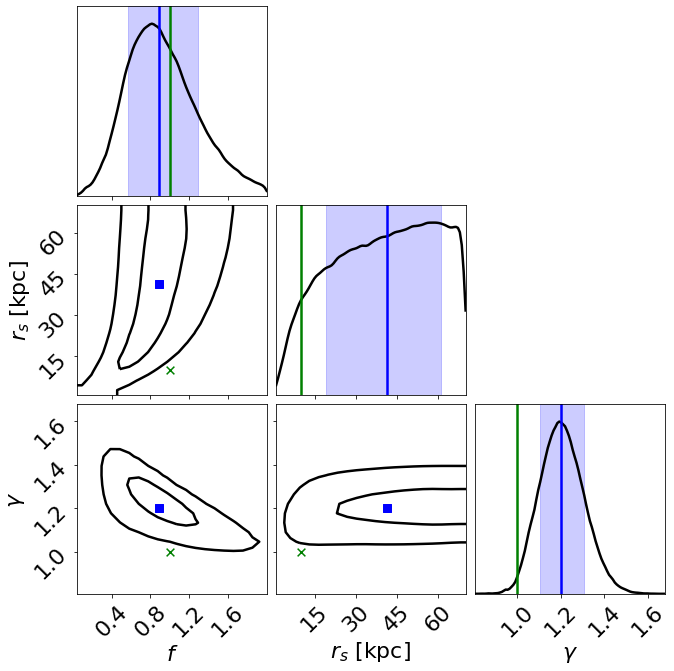

In [7]:
nBDs     = 1000 ; sigma= 0.1
f        = 1.; gamma    = 1.; rs = 10.

filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/fixedT10/N%isigma0.1/" %nBDs)
_file    = open(filepath + ("like_fixedT10v100_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv1" %(nBDs, sigma, gamma, rs)), "rb") 
like     = pickle.load(_file)
filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/fixedT10/N%isigma0.1/" %nBDs)
_file    = open(filepath + ("posterior_fixedT10v100_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv1" %(nBDs, sigma, gamma, rs)), "rb") 
samples  = pickle.load(_file)

smooth=1.
fig, axes = corner(np.array([samples[:, 0], samples[:, 2], samples[:, 1]]).T, 
                   levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="k",)
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], np.array([samples[:, 0], samples[:, 2], samples[:, 1]])):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5)      
    
axes[0, 0].axvline(1., color="g", ls="-", lw=2.5); axes[0, 0].axvline(np.median(samples[:, 0]), color="b", ls="-", lw=2.5)
axes[1, 1].axvline(rs, color="g", ls="-", lw=2.5); axes[1, 1].axvline(np.median(samples[:, 2]), color="b", ls="-", lw=2.5)
axes[2, 2].axvline(gamma, color="g", ls="-", lw=2.5); axes[2, 2].axvline(np.median(samples[:, 1]), color="b", ls="-", lw=2.5)
axes[1, 0].scatter(f, rs, marker="x", color="g", s=60); axes[1, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 2]), marker="s", color="b", s=60)
axes[2, 0].scatter(f, gamma, marker="x", color="g", s=60); axes[2, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 1]), marker="s", color="b", s=60)
axes[2, 1].scatter(rs, gamma, marker="x", color="g", s=60); axes[2, 1].scatter(np.median(samples[:, 2]), np.median(samples[:, 1]), marker="s", color="b", s=60)

axes[0, 0].axvspan(np.percentile(samples[:, 0], 16), np.percentile(samples[:, 0], 84), color="blue", alpha=0.2)
axes[1, 1].axvspan(np.percentile(samples[:, 2], 16), np.percentile(samples[:, 2], 84), color="blue", alpha=0.2)
axes[2, 2].axvspan(np.percentile(samples[:, 1], 16), np.percentile(samples[:, 1], 84), color="blue", alpha=0.2)

axes[1, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$\gamma$")
axes[2, 1].set_xlabel(r"$r_s$ [kpc]")
axes[2, 2].set_xlabel(r"$\gamma$")

#fig.savefig("1D2D_example.pdf", bbox_inches="tight")

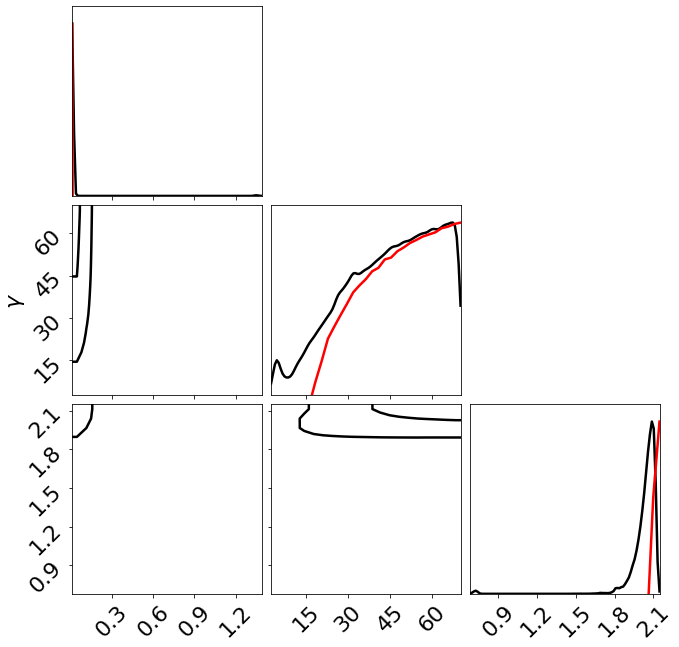

In [14]:
nBDs     = 100000 ; sigma= 0.2
f        = 1.; gamma    = 0.5; rs = 5.

filepath = ("/hdfs/local/sven/exoplanets/sig%.1f/gamma%.1frs%.1f/" %(sigma, gamma, rs))
_file    = open(filepath + ("like_fixedT10v100_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv8" %(nBDs, sigma, gamma, rs)), "rb") 
like     = pickle.load(_file)
filepath = ("/hdfs/local/sven/exoplanets/sig%.1f/gamma%.1frs%.1f/" %(sigma, gamma, rs))
_file    = open(filepath + ("posterior_fixedT10v100_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv8" %(nBDs, sigma, gamma, rs)), "rb") 
samples  = pickle.load(_file)

smooth=1.
fig, axes = corner(np.array([samples[:, 0], samples[:, 2], samples[:, 1]]).T, 
                   levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="k",)
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], np.array([samples[:, 0], samples[:, 2], samples[:, 1]])):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5)     

axes[1, 0].set_xlabel(r"$r_s$ [kpc]")
axes[1, 0].set_ylabel(r"$\gamma$")
axes[1, 1].set_xlabel(r"$\gamma$")


bin_n=30
x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]
x = x[~np.isnan(y)]
y = y[~np.isnan(y)] - np.max(y[~np.isnan(y)]) + 1
#print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[1, 1].plot(x, y, ls="-", color="r", lw=2.5)

x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
x = x[~np.isnan(y)]
y = y[~np.isnan(y)] - np.max(y[~np.isnan(y)]) + 1
#print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[2, 2].plot(x, y, ls="-", color="r", lw=2.5)

x = binned_statistic(samples[:, 0], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 0], like, 'max', bins=bin_n+1)[0]
x = x[~np.isnan(y)]
y = y[~np.isnan(y)] - np.max(y[~np.isnan(y)]) + 1
#print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[0, 0].plot(x, y, ls="-", color="r", lw=2.5)

#fig.savefig("1D2D_example_2.pdf", bbox_inches="tight")

In [26]:
like

array([-49518.52646735, -49520.48575353, -49521.00840917, ...,
       -49514.22160914, -49514.77966558, -49515.40735421])

In [27]:
bin_n=100

x = binned_statistic(samples[:, 0], -like, 'min', bins=bin_n)[1]                     
y = binned_statistic(samples[:, 0], -like, 'min', bins=bin_n+1)[0] 

print(x)
print(y)

[0.01000001 0.02380222 0.03760442 0.05140663 0.06520884 0.07901104
 0.09281325 0.10661545 0.12041766 0.13421987 0.14802207 0.16182428
 0.17562648 0.18942869 0.2032309  0.2170331  0.23083531 0.24463751
 0.25843972 0.27224193 0.28604413 0.29984634 0.31364854 0.32745075
 0.34125296 0.35505516 0.36885737 0.38265957 0.39646178 0.41026399
 0.42406619 0.4378684  0.4516706  0.46547281 0.47927502 0.49307722
 0.50687943 0.52068163 0.53448384 0.54828605 0.56208825 0.57589046
 0.58969266 0.60349487 0.61729708 0.63109928 0.64490149 0.65870369
 0.6725059  0.68630811 0.70011031 0.71391252 0.72771472 0.74151693
 0.75531914 0.76912134 0.78292355 0.79672575 0.81052796 0.82433017
 0.83813237 0.85193458 0.86573678 0.87953899 0.8933412  0.9071434
 0.92094561 0.93474781 0.94855002 0.96235223 0.97615443 0.98995664
 1.00375884 1.01756105 1.03136326 1.04516546 1.05896767 1.07276987
 1.08657208 1.10037429 1.11417649 1.1279787  1.1417809  1.15558311
 1.16938531 1.18318752 1.19698973 1.21079193 1.22459414 1.23839

In [28]:
from scipy.interpolate import UnivariateSpline

def LI(L, samples, bin_n=40, verbose=False):                                    
    """                                                                         
    For each parameter, construct profile likelihood and return the profile likelihood interval
    (i.e. region where the log Likelihood is within 1 of its maximum value)     
                                                                                
    """                                                                         
    # Create bins in Likelihood vs parameter space, find the max Likelihood     
    # value in each bin and the corresponding parameter values                  
    x = binned_statistic(samples, -L, 'min', bins=bin_n)[1]                     
    y = binned_statistic(samples, -L, 'min', bins=bin_n+1)[0]                   
                                                                                
    # Create Interpolation fanction Likelihood - parameter                      
    #pdb.set_trace() 
    print("Above Univariate Spline")
    z =  UnivariateSpline(x[~np.isnan(y)], y[~np.isnan(y)], s=0) 
    print("Below Univariate Spline")
                                                                                
    # Find in which points crosses 1sigma horizontal line (where 1 sigma        
    # corresponds to 1/2 -for 1 dof-)                                           
    x_tmin     = np.min(samples)                                                
    epsilon    = 1                                                              
    niteration = 0                                                              
    logLmin    = np.min(y[~np.isnan(y)]) + 1.                                   
    while epsilon > 10**-6 and niteration < 20:                                 
        niteration +=1                                                          
        minimum = minimize(lambda x: (z(x)-logLmin)**2, x_tmin,                 
                           bounds=((np.min(samples), samples[np.argmax(L)]),))  
        epsilon = minimum.fun                                                   
        x_tmin  = x_tmin*1.1                                                    
        _min    = minimum.x                                                     
                                                                                
    if epsilon < 10**-6:                                                        
        LImin = _min[0]                                                         
    else:                                                                       
        LImin = np.min(samples)                                                 
                                                                                
    x_tmax     = samples[np.argmax(L)]                                          
    epsilon    = 1                                                              
    niteration = 0                                                              
    while epsilon > 10**-6 and niteration < 25:                                 
        niteration +=1                                                          
        maximum = minimize(lambda x: (z(x)-logLmin)**2, x_tmax,                 
                           bounds=((samples[np.argmax(L)], np.max(samples)),))  
        epsilon  = maximum.fun                                                  
        x_tmax  = x_tmax*1.1                                                    
        _max    = maximum.x                                                     
                                                                                
    if epsilon < 10**-6:                                                        
        LImax = _max[0]                                                         
    else:                                                                       
        LImax = np.max(samples)                                                 
                                                                                
    if verbose==True:                                                           
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))                            
        ax.plot(x, y, color="k", lw=2.5)                                        
        ax.axvline(LImin, color="g"); ax.axvline(LImax, color="g")              
                                                                                
    #Return                                                                     
    return  LImin, LImax

D=3
for j in range(D):                                                         
    _min, _max   = LI(like, samples[:, j])                                 
    LI_min = _min                                                    
    LI_max = _max 
    print(LI_min, LI_max)

Above Univariate Spline
Below Univariate Spline


NameError: name 'minimize' is not defined

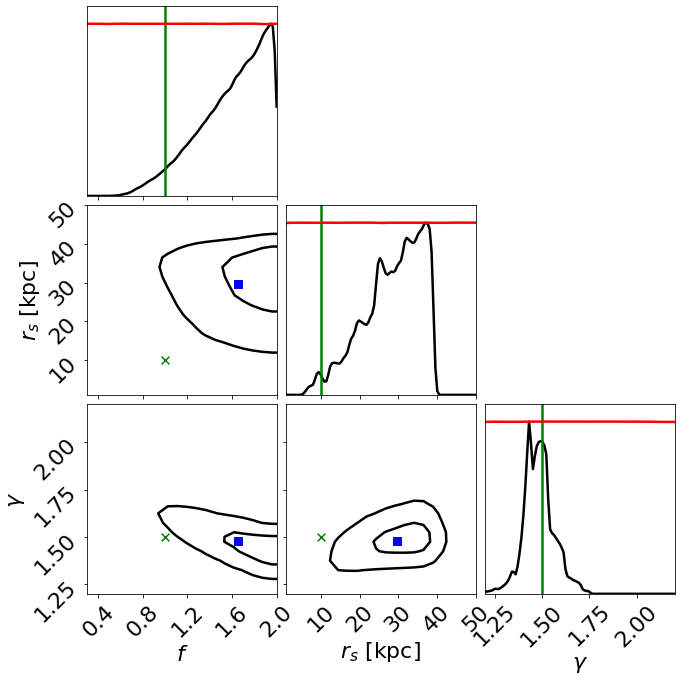

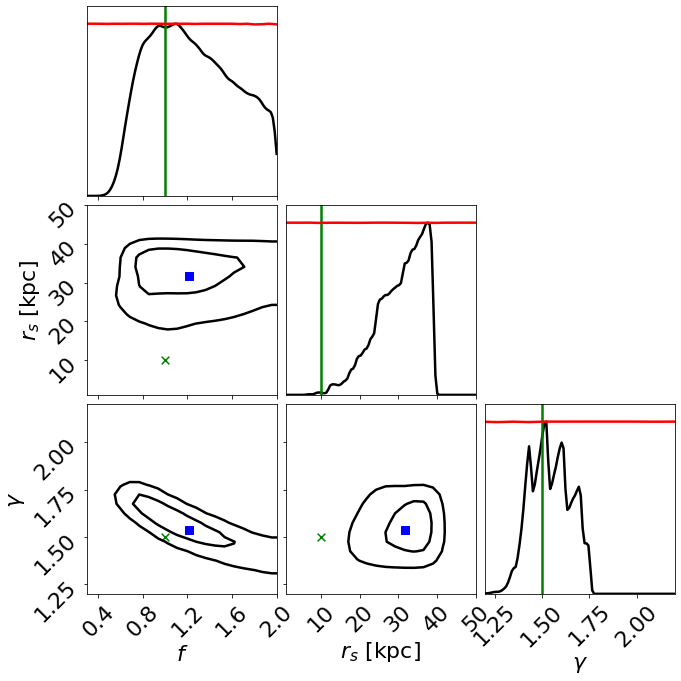

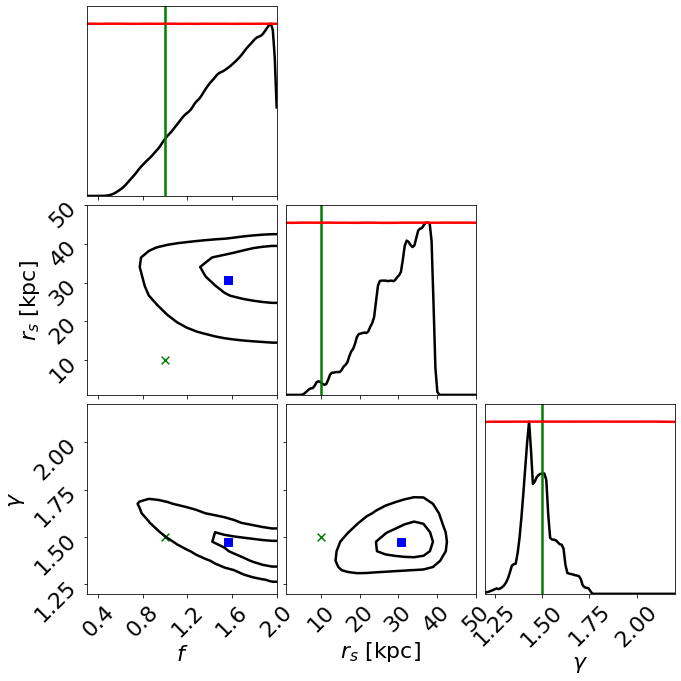

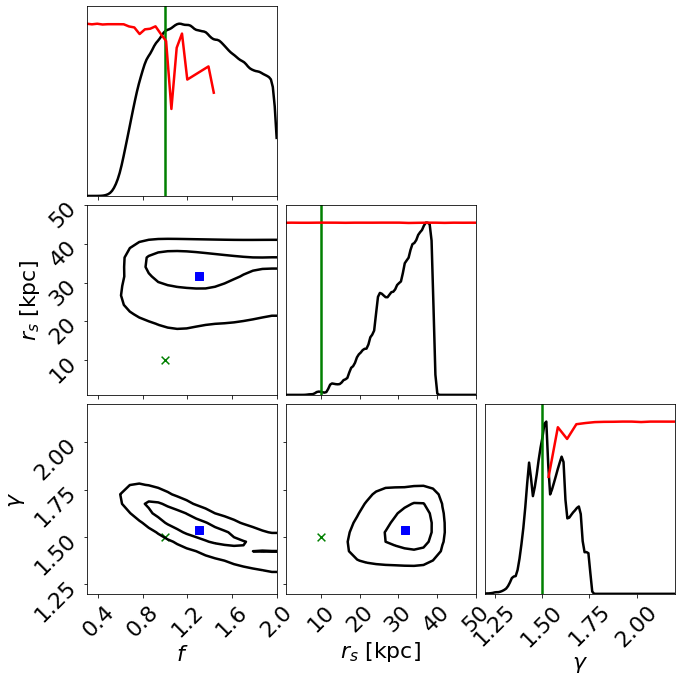

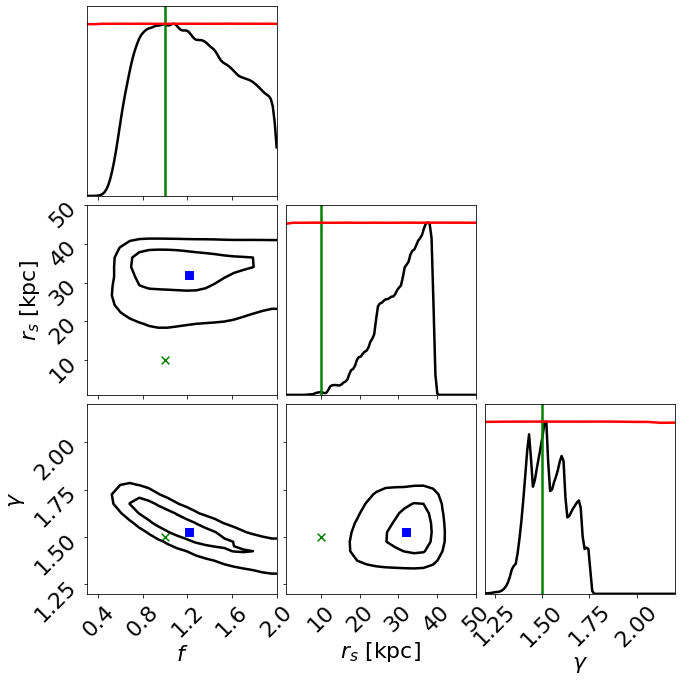

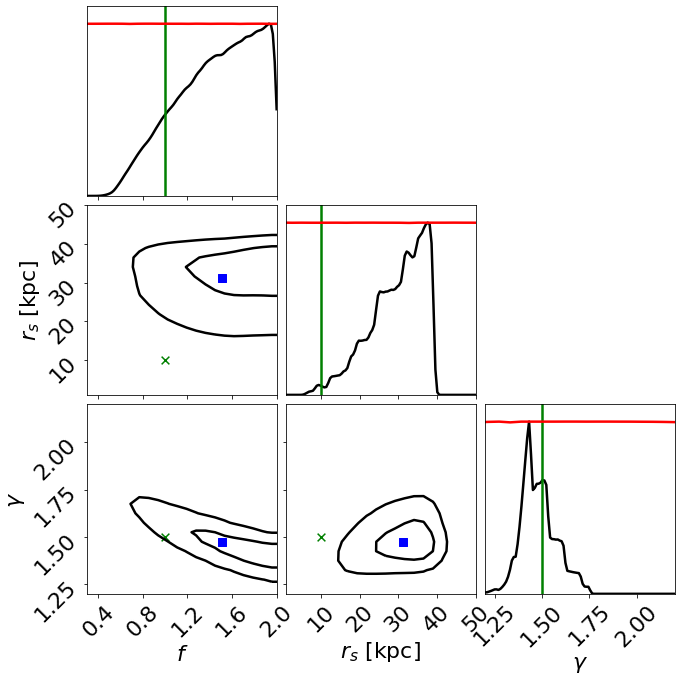

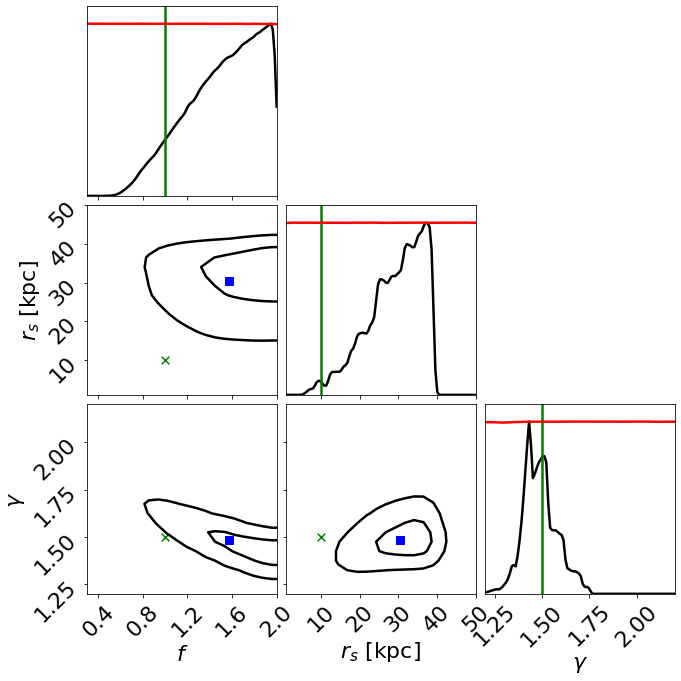

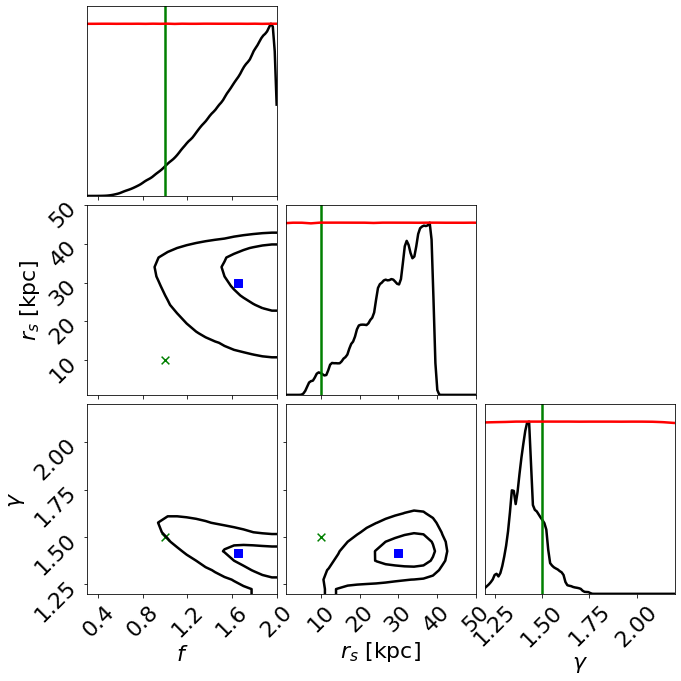

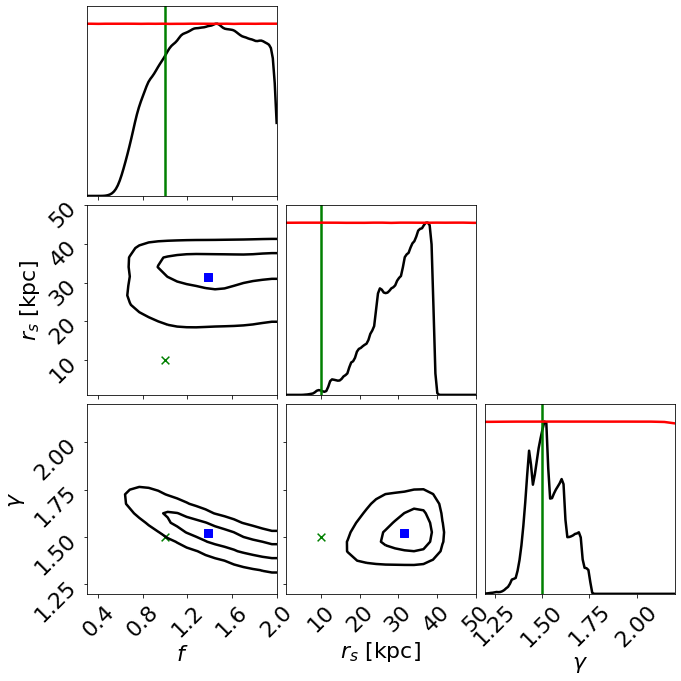

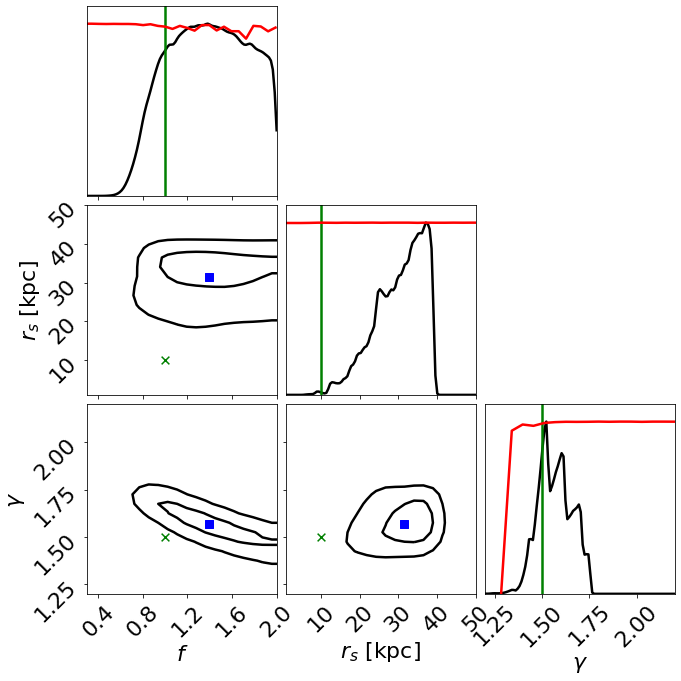

In [13]:
nBDs = 100 ; sigma= 0.2
f = 1.; gamma = 1.5; rs = 10.
rank=1

for rank in range(10):
    rank = rank+26
    
    filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/priorsRC/N%isigma%.1f/" 
                %(nBDs, sigma))
    _file    = open(filepath + ("posterior_priorsRC_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs, sigma, gamma, rs, rank)), "rb") 
    samples  = pickle.load(_file)
    
    smooth=1.
    fig, axes = corner(np.array([samples[:, 0], samples[:, 2], samples[:, 1]]).T, 
                       levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                       plot_density=False, fill_contours=False, smooth=smooth, color="k",
                       range=([0.3, 2.], [1., 50.], [1.2, 2.2]))
    # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 4, 8], np.array([samples[:, 0], samples[:, 2], samples[:, 1]])):
        kde   = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5)      
        
    axes[0, 0].axvline(1., color="g", ls="-", lw=2.5); #axes[0, 0].axvline(np.median(samples[:, 0]), color="k", ls="-", lw=2.5)
    axes[1, 1].axvline(rs, color="g", ls="-", lw=2.5); #axes[1, 1].axvline(np.median(samples[:, 2]), color="k", ls="-", lw=2.5)
    axes[2, 2].axvline(gamma, color="g", ls="-", lw=2.5); #axes[2, 2].axvline(np.median(samples[:, 1]), color="k", ls="-", lw=2.5)
    axes[1, 0].scatter(f, rs, marker="x", color="g", s=60); axes[1, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 2]), marker="s", color="b", s=60)
    axes[2, 0].scatter(f, gamma, marker="x", color="g", s=60); axes[2, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 1]), marker="s", color="b", s=60)
    axes[2, 1].scatter(rs, gamma, marker="x", color="g", s=60); axes[2, 1].scatter(np.median(samples[:, 2]), np.median(samples[:, 1]), marker="s", color="b", s=60)
    
    filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/fixedT10/N%isigma%.1f/" 
                %(nBDs, sigma))
    _file    = open(filepath + ("like_fixedT10v100_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv1" %(nBDs, sigma, gamma, rs)), "rb") 
    like     = pickle.load(_file)
    filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/fixedT10/N%isigma%.1f/" 
                %(nBDs, sigma))

    _file    = open(filepath + ("posterior_fixedT10v100_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs, sigma, gamma, rs, rank)), "rb") 
    samples  = pickle.load(_file)
    
    bin_n=30
    x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
    y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)] - np.max(y[~np.isnan(y)]) + 1
    #print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
    axes[1, 1].plot(x, y, ls="-", color="r", lw=2.5)
    
    x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
    y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)] - np.max(y[~np.isnan(y)]) + 1
    #print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
    axes[2, 2].plot(x, y, ls="-", color="r", lw=2.5)
    
    x = binned_statistic(samples[:, 0], like, 'max', bins=bin_n)[1] 
    y = binned_statistic(samples[:, 0], like, 'max', bins=bin_n+1)[0]
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)] - np.max(y[~np.isnan(y)]) + 1
    #print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
    axes[0, 0].plot(x, y, ls="-", color="r", lw=2.5)
    
    axes[1, 0].set_ylabel(r"$r_s$ [kpc]")
    axes[2, 0].set_xlabel(r"$f$")
    axes[2, 0].set_ylabel(r"$\gamma$")
    axes[2, 1].set_xlabel(r"$r_s$ [kpc]")
    axes[2, 2].set_xlabel(r"$\gamma$")
    
    fig.savefig("corner_priorsRC_nBDs%isigma%.1f_gamma%.1frs%.1f_v%i.png"%(nBDs, sigma, gamma, rs, rank),
                bbox_inches="tight")

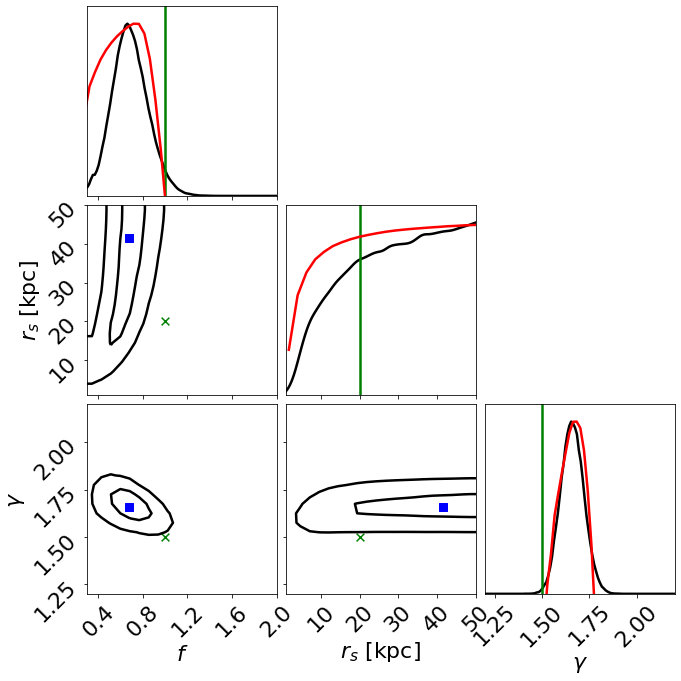

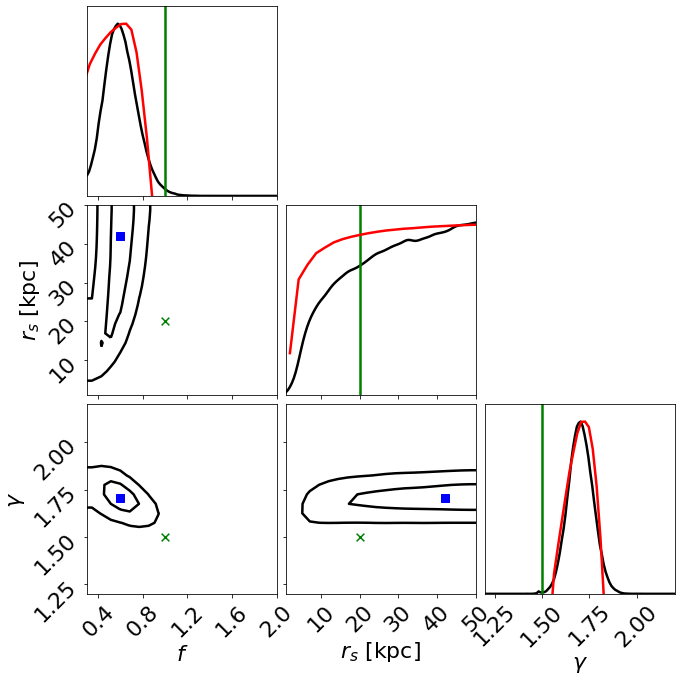

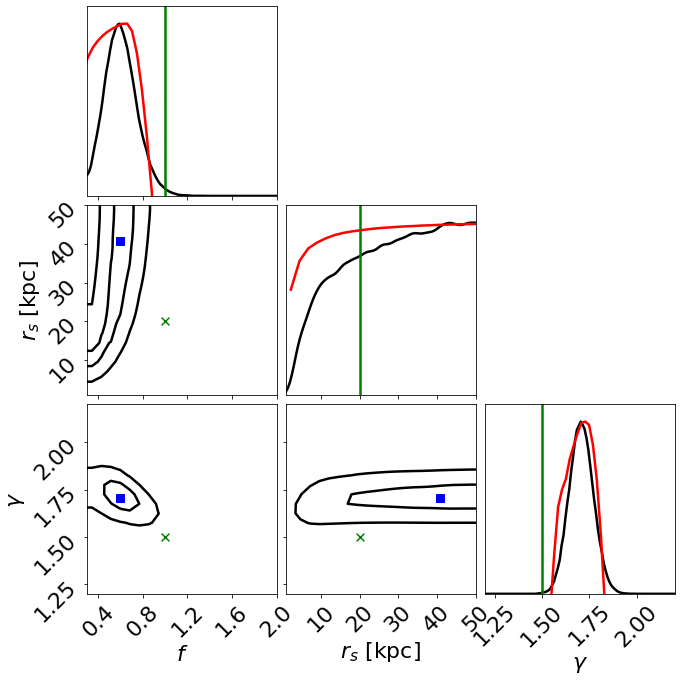

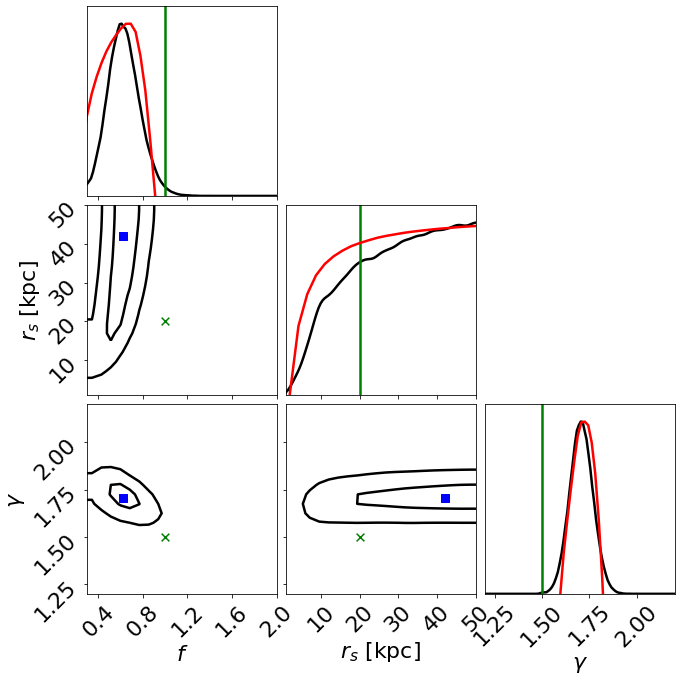

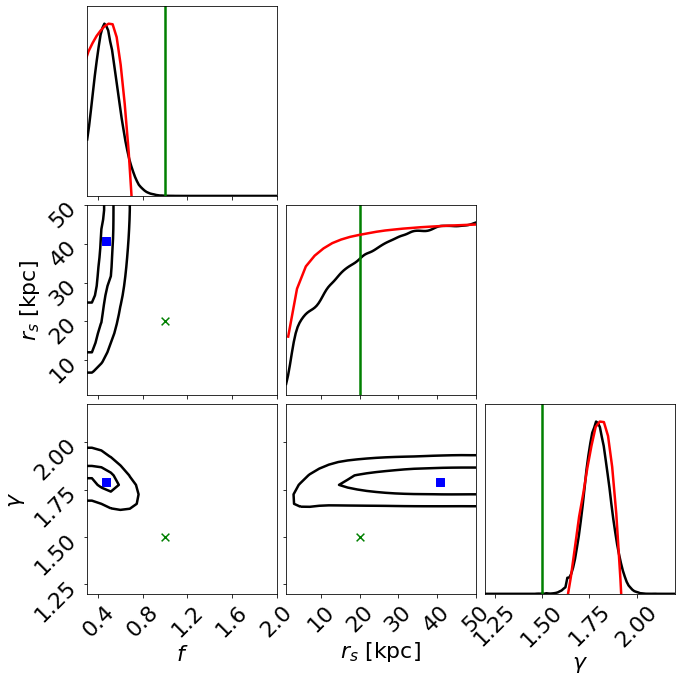

In [53]:
nBDs = 1000 ; sigma= 0.2
f  = 1.; gamma = 1.5; rs = 20.
rank=1

for rank in range(5):
    rank = rank+1
    filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v30/fixedT10/N%isigma%.1f/" 
                %(nBDs, sigma))
    _file    = open(filepath + ("like_fixedT10v30_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs, sigma, gamma, rs, rank)), "rb") 
    like     = pickle.load(_file)
    filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v30/fixedT10/N%isigma%.1f/" 
                %(nBDs, sigma))
    _file    = open(filepath + ("posterior_fixedT10v30_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs, sigma, gamma, rs, rank)), "rb") 
    samples  = pickle.load(_file)
    
    smooth=1.
    fig, axes = corner(np.array([samples[:, 0], samples[:, 2], samples[:, 1]]).T, 
                       levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                       plot_density=False, fill_contours=False, smooth=smooth, color="k",
                       range=([0.3, 2.], [1., 50.], [1.2, 2.2]))
    # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 4, 8], np.array([samples[:, 0], samples[:, 2], samples[:, 1]])):
        kde   = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5)      
        
    axes[0, 0].axvline(1., color="g", ls="-", lw=2.5); #axes[0, 0].axvline(np.median(samples[:, 0]), color="k", ls="-", lw=2.5)
    axes[1, 1].axvline(rs, color="g", ls="-", lw=2.5); #axes[1, 1].axvline(np.median(samples[:, 2]), color="k", ls="-", lw=2.5)
    axes[2, 2].axvline(gamma, color="g", ls="-", lw=2.5); #axes[2, 2].axvline(np.median(samples[:, 1]), color="k", ls="-", lw=2.5)
    axes[1, 0].scatter(f, rs, marker="x", color="g", s=60); axes[1, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 2]), marker="s", color="b", s=60)
    axes[2, 0].scatter(f, gamma, marker="x", color="g", s=60); axes[2, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 1]), marker="s", color="b", s=60)
    axes[2, 1].scatter(rs, gamma, marker="x", color="g", s=60); axes[2, 1].scatter(np.median(samples[:, 2]), np.median(samples[:, 1]), marker="s", color="b", s=60)
    
    
    axes[1, 0].set_ylabel(r"$r_s$ [kpc]")
    axes[2, 0].set_xlabel(r"$f$")
    axes[2, 0].set_ylabel(r"$\gamma$")
    axes[2, 1].set_xlabel(r"$r_s$ [kpc]")
    axes[2, 2].set_xlabel(r"$\gamma$")
    
    bin_n=30
    x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
    y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)] - np.max(y[~np.isnan(y)]) + 1
    #print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
    axes[1, 1].plot(x, y, ls="-", color="r", lw=2.5)
    
    x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
    y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)] - np.max(y[~np.isnan(y)]) + 1
    #print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
    axes[2, 2].plot(x, y, ls="-", color="r", lw=2.5)
    
    x = binned_statistic(samples[:, 0], like, 'max', bins=bin_n)[1] 
    y = binned_statistic(samples[:, 0], like, 'max', bins=bin_n+1)[0]
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)] - np.max(y[~np.isnan(y)]) + 1
    #print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
    axes[0, 0].plot(x, y, ls="-", color="r", lw=2.5)
    
    fig.savefig("corner_fixedT10v30_nBDs%isigma%.1f_gamma%.1frs%.1f_v%i.png"%(nBDs, sigma, gamma, rs, rank),
                bbox_inches="tight")

6.576803522951829 69.9998628736691    -0.8036169121551211 1.0
1.3508218242963284 1.5630428618149208    -6.896155341921258 1.0
0.16290053459925474 0.6234061939307927    -7.705722055936349 1.0


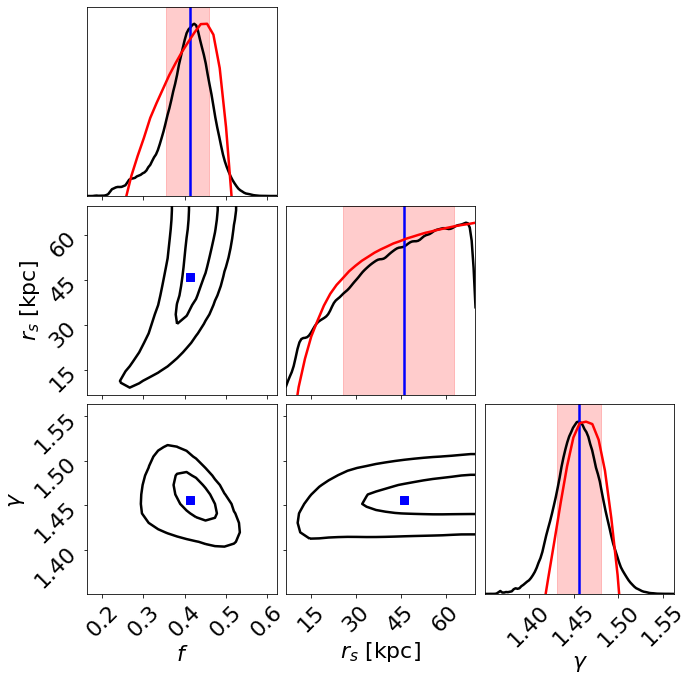

In [18]:
nBDs = 100000 ; sigma= 0.2
f    = 1.; gamma = 0.8; rs = 5.

filepath = ("/hdfs/local/sven/exoplanets/sig%.1f/gamma%.1frs%.1f/" %(sigma, gamma, rs))
_file    = open(filepath + ("like_fixedT10v100_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv5" 
                            %(nBDs, sigma, gamma, rs)), "rb") 
like     = pickle.load(_file)
_file    = open(filepath + ("posterior_fixedT10v100_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv5" 
                            %(nBDs, sigma, gamma, rs)), "rb") 
samples  = pickle.load(_file)

smooth=1.
fig, axes = corner(np.array([samples[:, 0], samples[:, 2], samples[:, 1]]).T, 
                   levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="k",)
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], np.array([samples[:, 0], samples[:, 2], samples[:, 1]])):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5)      
    
axes[0, 0].axvline(1., color="g", ls="-", lw=2.5); axes[0, 0].axvline(np.median(samples[:, 0]), color="b", ls="-", lw=2.5)
axes[1, 1].axvline(rs, color="g", ls="-", lw=2.5); axes[1, 1].axvline(np.median(samples[:, 2]), color="b", ls="-", lw=2.5)
axes[2, 2].axvline(gamma, color="g", ls="-", lw=2.5); axes[2, 2].axvline(np.median(samples[:, 1]), color="b", ls="-", lw=2.5)
axes[1, 0].scatter(f, rs, marker="x", color="g", s=60); axes[1, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 2]), marker="s", color="b", s=60)
axes[2, 0].scatter(f, gamma, marker="x", color="g", s=60); axes[2, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 1]), marker="s", color="b", s=60)
axes[2, 1].scatter(rs, gamma, marker="x", color="g", s=60); axes[2, 1].scatter(np.median(samples[:, 2]), np.median(samples[:, 1]), marker="s", color="b", s=60)

axes[0, 0].axvspan(np.percentile(samples[:, 0], 16), np.percentile(samples[:, 0], 84), color="red", alpha=0.2)
axes[1, 1].axvspan(np.percentile(samples[:, 2], 16), np.percentile(samples[:, 2], 84), color="red", alpha=0.2)
axes[2, 2].axvspan(np.percentile(samples[:, 1], 16), np.percentile(samples[:, 1], 84), color="red", alpha=0.2)

axes[1, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$\gamma$")
axes[2, 1].set_xlabel(r"$r_s$ [kpc]")
axes[2, 2].set_xlabel(r"$\gamma$")

bin_n=30
x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[1, 1].plot(x, y, ls="-", color="r", lw=2.5)

x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[2, 2].plot(x, y, ls="-", color="r", lw=2.5)

x = binned_statistic(samples[:, 0], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 0], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[0, 0].plot(x, y, ls="-", color="r", lw=2.5)

Text(0, 0.5, '-ln($\\mathcal{L}$)')

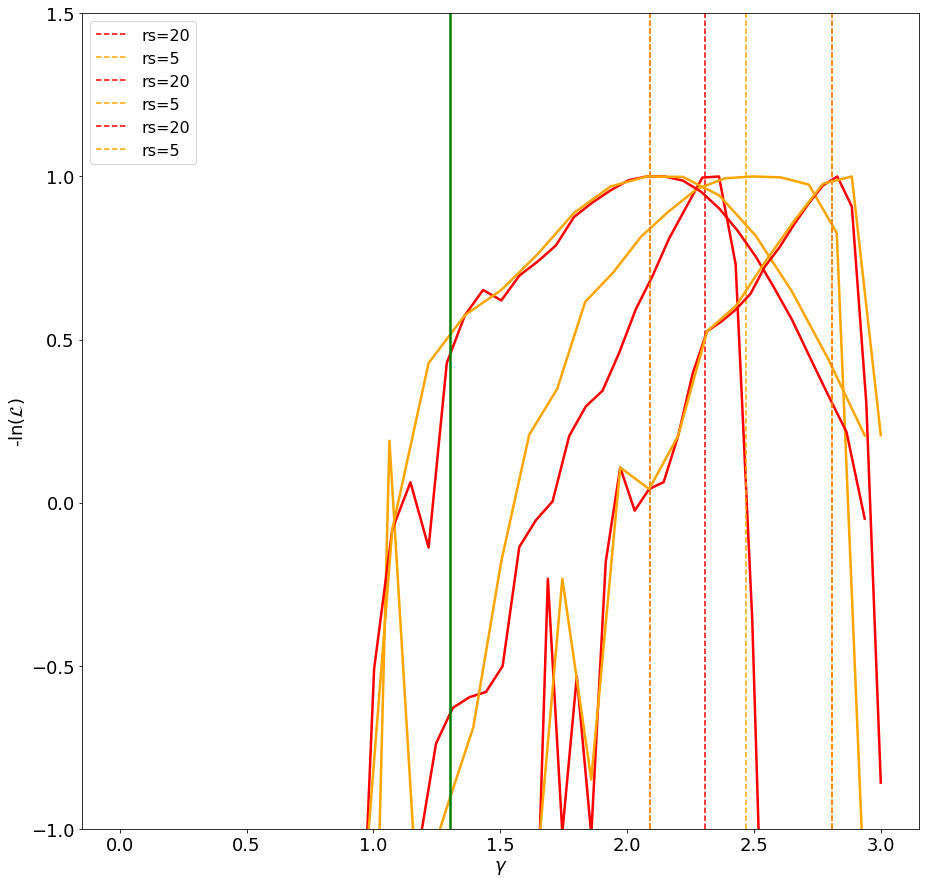

In [19]:
nBDs     = 100; sigma= 0.3
f        = 1.; gamma = 1.3; rs = 20.
rank = 88

fig, axes = plt.subplots(1, 1, figsize=(15, 15))
     
    
#axes.axvline(gamma, color="red", ls="-", lw=2.5, label=r"$\gamma=%.1f$, $r_s$=20 kpc" %gamma)
axes.set_xlabel(r"$\gamma$")

for i in range(3):
    rank = i+1
    filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/fixedT10v100reconstv30/N%isigma%.1f/" 
                %(nBDs, sigma))
    _file    = open(filepath + ("like_fixedT10v100reconstv30_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs, sigma, gamma, rs, rank)), "rb") 
    like     = pickle.load(_file)
    filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/fixedT10v100reconstv30/N%isigma%.1f/" 
                %(nBDs, sigma))
    _file    = open(filepath + ("posterior_fixedT10v100reconstv30_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs, sigma, gamma, rs, rank)), "rb") 
    samples  = pickle.load(_file)
    bin_n=40
    x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
    y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
    #print(x, y)
    y = y - np.max(y[~np.isnan(y)]) + 1
    #print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
    axes.plot(x, y, ls="-", color="r", lw=2.5)
    axes.axvline(samples[:, 1][np.argmax(like)], color="red", ls="--", label="rs=20")
    #print(samples[:, 1][np.argmax(like)])
    
    
    #kde   = gaussian_kde(samples.T[1])
    #xvals = np.linspace(0., 2.8, 100)
    #axes.plot(xvals, kde(xvals)/np.max(kde(xvals)), color="red", lw=2.5, ls=":")   
    
    #axes.axvline(gamma, color="orange", ls="-", lw=2.5, label=r"$\gamma=%.1f$, $r_s$=20 kpc" %gamma)
    rs=5.
    filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/fixedT10v100reconstv30/N%isigma%.1f/" 
                %(nBDs, sigma))
    _file    = open(filepath + ("like_fixedT10v100reconstv30_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs, sigma, gamma, rs, rank)), "rb") 
    like     = pickle.load(_file)
    filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/fixedT10v100reconstv30/N%isigma%.1f/" 
                %(nBDs, sigma))
    _file    = open(filepath + ("posterior_fixedT10v100reconstv30_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs, sigma, gamma, rs, rank)), "rb") 
    samples  = pickle.load(_file)
    bin_n=20
    x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
    y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
    #print(x, y)
    y = y - np.max(y[~np.isnan(y)]) + 1
    #print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
    axes.plot(x, y, ls="-", color="orange", lw=2.5)
    axes.axvline(samples[:, 1][np.argmax(like)], color="orange", ls="--", label="rs=5")

#kde   = gaussian_kde(samples.T[1])
#xvals = np.linspace(0., 2.8, 100)
#axes.plot(xvals, kde(xvals)/np.max(kde(xvals)), color="orange", lw=2.5, ls=":")   

axes.set_ylim(-1, 1.5)
axes.legend(fontsize=16)

axes.axvline(gamma, color="green", lw=2.5)
axes.set_ylabel(r"-ln($\mathcal{L}$)")

#fig.savefig("fixedT10v100_likelihood_base_vs_cut_nBDs%i_sigma%.1i_gamma%.1frs%.1f.png"%(nBDs, sigma, gamma, rs), 
#            bbox_inches="tight")

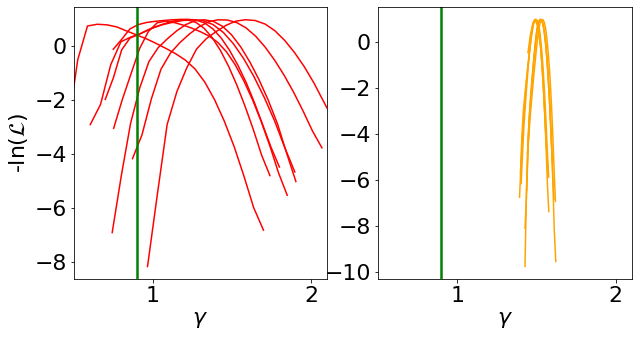

In [13]:
nBDs1 = 1000; nBDs2 = 100000
sigma = 0.2
f     = 1.; gamma = 0.9; rs = 5.


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
     
    
axes[0].set_xlabel(r"$\gamma$"); axes[1].set_xlabel(r"$\gamma$")

smooth=0.8

for i in range(8):
    rank = i + 3
    filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/fixedT10/N%isigma%.1fb/" 
                %(nBDs1, sigma))
    _file    = open(filepath + ("like_fixedT10v100_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs1, sigma, gamma, rs, rank)), "rb") 
    like     = pickle.load(_file)
    filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/fixedT10/N%isigma%.1fb/" 
                %(nBDs1, sigma))
    _file    = open(filepath + ("posterior_fixedT10v100_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs1, sigma, gamma, rs, rank)), "rb") 
    samples  = pickle.load(_file)
    bin_n=20
    x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
    y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
    y = y - np.max(y[~np.isnan(y)]) + 1
    axes[0].plot(x, gaussian_filter1d(y, sigma=smooth), ls="-", color="r")
    
    filepath = ("/hdfs/local/sven/exoplanets/sig%.1f/gamma%.1frs%.1f/" 
                %(sigma, gamma, rs))
    _file    = open(filepath + ("like_fixedT10v100_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs2, sigma, gamma, rs, rank)), "rb") 
    like     = pickle.load(_file)
    _file    = open(filepath + ("posterior_fixedT10v100_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs2, sigma, gamma, rs, rank)), "rb") 
    samples  = pickle.load(_file)
    bin_n=20
    x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
    y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
    y = y - np.max(y[~np.isnan(y)]) + 1
    axes[1].plot(x, gaussian_filter1d(y, sigma=smooth), ls="-", color="orange")

#axes[0].set_ylim(-1, 1.5); axes[1].set_ylim(-1, 1.5)
axes[0].set_xlim(0.5, 2.1); axes[1].set_xlim(0.5, 2.1)

#axes[0].text(1.7, 1.12, "$r_s$=%i kpc"%int(rs), fontsize=16)
#axes[1].text(1.52, 1.12, "N=%i, sigma=%.1f"%(nBDs, sigma), fontsize=16)

#axes[0].text(1.03, -0.7, "cut 650 K", fontsize=16)
#axes[1].text(1.03, -0.7, "baseline", fontsize=16)
axes[0].set_ylabel(r"-ln($\mathcal{L}$)")
    
axes[0].axvline(gamma, color="green", lw=2.5); axes[1].axvline(gamma, color="green", lw=2.5)

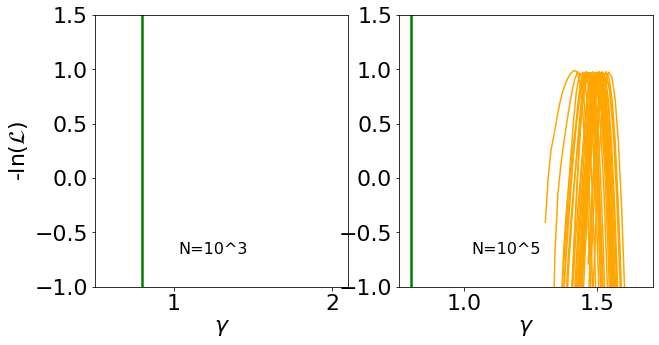

In [20]:
nBDs1 = 1000; nBDs2 = 100000
sigma = 0.2
f     = 1.; gamma = 0.8; rs = 5.


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
     
    
axes[0].set_xlabel(r"$\gamma$"); axes[1].set_xlabel(r"$\gamma$")

smooth=0.8

for i in range(28):
    rank = i + 3
    #filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/fixedT10/N%isigma%.1fb/" 
    #            %(nBDs1, sigma))
    #_file    = open(filepath + ("like_fixedT10v100_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
    #                            %(nBDs1, sigma, gamma, rs, rank)), "rb") 
    #like     = pickle.load(_file)
    #filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/fixedT10/N%isigma%.1fb/" 
    #            %(nBDs1, sigma))
    #_file    = open(filepath + ("posterior_fixedT10v100_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
    #                            %(nBDs1, sigma, gamma, rs, rank)), "rb") 
    #samples  = pickle.load(_file)
    #bin_n=20
    #x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
    #y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
    #y = y - np.max(y[~np.isnan(y)]) + 1
    #axes[0].plot(x, gaussian_filter1d(y, sigma=smooth), ls="-", color="r")
    
    filepath = ("/hdfs/local/sven/exoplanets/sig%.1f/gamma%.1frs%.1f/" 
                %(sigma, gamma, rs))
    _file    = open(filepath + ("like_fixedT10v100_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs2, sigma, gamma, rs, rank)), "rb") 
    like     = pickle.load(_file)
    _file    = open(filepath + ("posterior_fixedT10v100_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs2, sigma, gamma, rs, rank)), "rb") 
    samples  = pickle.load(_file)
    bin_n=20
    x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
    y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
    y = y - np.max(y[~np.isnan(y)]) + 1
    axes[1].plot(x, gaussian_filter1d(y, sigma=smooth), ls="-", color="orange")

    
axes[0].set_ylim(-1, 1.5); axes[1].set_ylim(-1, 1.5)
axes[0].set_xlim(0.5, 2.1); #axes[1].set_xlim(0.5, 2.1)

#axes[0].text(1.7, 1.12, "$r_s$=%i kpc"%int(rs), fontsize=16)
#axes[1].text(1.52, 1.12, "N=%i, sigma=%.1f"%(nBDs, sigma), fontsize=16)

axes[0].text(1.03, -0.7, "N=10^3", fontsize=16)
axes[1].text(1.03, -0.7, "N=10^5", fontsize=16)
axes[0].set_ylabel(r"-ln($\mathcal{L}$)")
    
axes[0].axvline(gamma, color="green", lw=2.5); axes[1].axvline(gamma, color="green", lw=2.5)

#fig.savefig("fixedT10v100_likelihood_gamma_sigma%.1f_gamma%.1frs%.1f.png"%(sigma, gamma, rs), 
#            bbox_inches="tight")

In [42]:
ex = "fixedT10v100"; nBDs = 100000; gamma_true=0.8; sigma=0.2; rs_true=5.
rank=16
path="/home/mariacst/exoplanets/running/v100_N1e5/"
(robs, sigmarobs, Tobs, sigmaTobs, 
 Mobs, sigmaMobs, Aobs, sigmaAobs) = np.genfromtxt(path + "obs_" + ex + "_N%i_sigma%.1f_gamma%.1f_rs%.1f_v%i.dat"                 
                                                   %(nBDs, sigma, gamma_true, rs_true, rank), unpack=True)

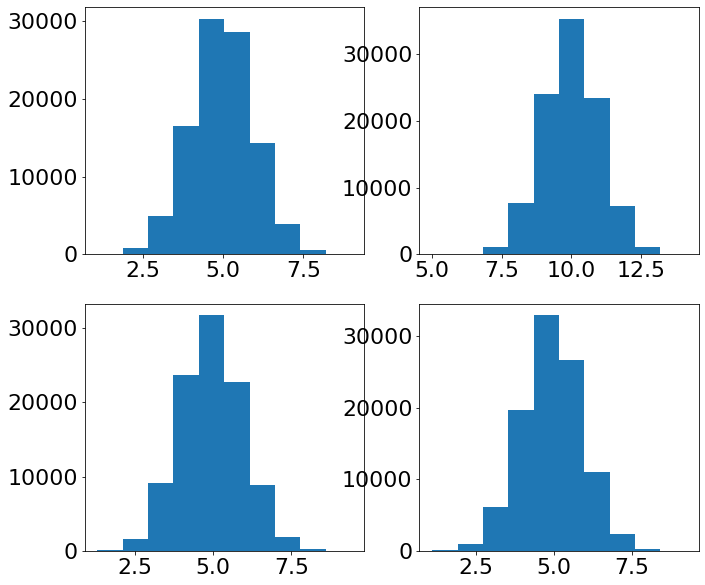

In [43]:

fig, ax = plt.subplots(2, 2, figsize=(11, 10))

ax[0, 0].hist(robs/sigmarobs);
ax[0, 1].hist(Tobs/sigmaTobs);
ax[1, 0].hist(Mobs/sigmaMobs);
ax[1, 1].hist(Aobs/sigmaAobs);

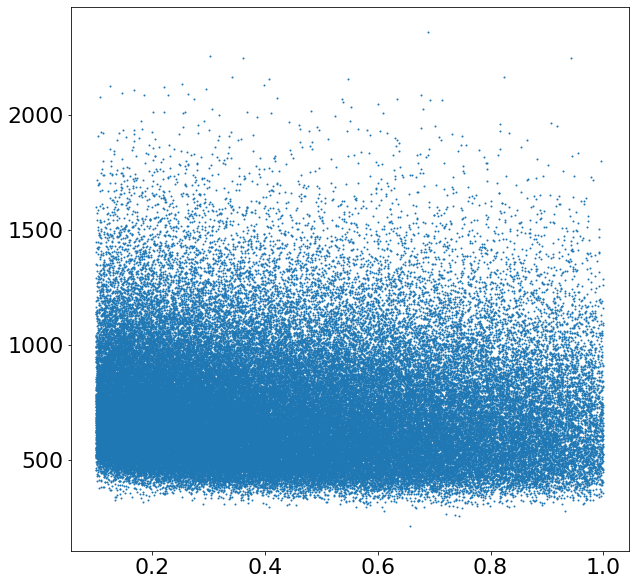

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(robs, Tobs, s=1)

In [45]:
from derivatives import derivativeTDM_wrt_M, derivativeTDM_wrt_r                
from utils import T_DM, temperature_withDM 

def sigma_Tmodel2(r, M, A, sigma_r, sigma_M, sigma_A,                              
                  Tint, points, values, dervTint_M, dervTint_A, f, params,         
                  v=None, R=R_jup.value, Rsun=8.178, epsilon=1):                   
    """                                                                         
    Return squared uncertainty in model temperature [UNITS??]                   
                                                                                
    Input:                                                                      
        r : Galactocentric distance [kpc]                                       
        M : mass [Msun]                                                         
        A : age [Gyr]                                                           
                                                                                
    Assumption: uncertainties in age, mass and galactocentric distance          
        are independent                                                         
    """                                                                            
    M_in_kg = M*conv_Msun_to_kg                                                    
                                                                                   
    _TDM = T_DM(r, R=R, M=M_in_kg, Rsun=Rsun, f=f, params=params, v=v,             
                epsilon=epsilon)                                                   
    Ttot = np.power(_TDM**4 + Tint**4, 0.25)                                       
                                                                                   
    dervT_M = ((Tint/Ttot)**3*dervTint_M +                                         
               (_TDM/Ttot)**3*derivativeTDM_wrt_M(r, f, params, M, v=v, R=R,       
                                                  Rsun=Rsun,epsilon=epsilon))   
    # return                                                                    
    return (np.power((Tint/Ttot)**3*dervTint_A*sigma_A, 2)+                        
            np.power(dervT_M*sigma_M, 2)+                                          
            np.power((_TDM/Ttot)**3*derivativeTDM_wrt_r(r, f, params, M, v=v,   
                                  R=R, Rsun=Rsun, epsilon=epsilon)*sigma_r, 2))

def residual(p, robs, sigma_robs, Mobs, sigma_Mobs, Aobs, sigma_Aobs,             
             Tobs, sigma_Tobs, Tint, points, values, dervTint_M, dervTint_A,      
             v, R, Rsun, rho0, epsilon):                                          
    """                                                                         
    Log likelihood function (without normalization!)                            
    """                                                                           
    # unroll free parameters                                                    
    f, gamma, rs = p                                                            
    # model temperature [K]                                                     
    Tmodel = temperature_withDM(robs, Tint, M=Mobs*conv_Msun_to_kg, f=f,        
                                p=[gamma, rs, rho0], v=v)                       
                                                                                
    _sigma_Tmodel2 = sigma_Tmodel2(robs, Mobs, Aobs, sigma_robs, sigma_Mobs,    
                                   sigma_Aobs, Tint, points, values, dervTint_M,
                                   dervTint_A,                                  
                                   f, [gamma, rs, rho0], v=v, R=R, Rsun=Rsun,   
                                   epsilon=epsilon)                             
    # return                                                                    
    return -0.5*np.sum((Tmodel-Tobs)**2/(sigma_Tobs**2 + _sigma_Tmodel2))

# Load theoretical cooling model                                                   
path = "/home/mariacst/exoplanets/running/data/"                                   
data = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)               
points = np.transpose(data[0:2, :])                                                
values = data[2]

# Load derivatives Tint wrt Age and Mass

path="/home/mariacst/exoplanets/running/v100_N1e5/"
data = np.genfromtxt(path + "data_der/derivativeTint_" + ex + "_N%i_sigma%.1f_v%i.dat" 
                     %(nBDs, sigma, rank), unpack=True)                            
dervTint_A = data[0]                                                               
dervTint_M = data[1] 

conversion_into_K_vs_kg = 1.60217e-7                                               
conversion_into_w       = 0.16021766                                               
conv_Msun_to_kg         = 1.98841e+30

In [56]:
p = [0.4, 0.6, 10.]
xi       = np.transpose(np.asarray([Aobs, Mobs]))                                  
Teff     = griddata(points, values, xi)

residual(p, robs, sigmarobs, Mobs, sigmaMobs, Aobs, sigmaAobs, Tobs, sigmaTobs, Teff, points, values, 
         dervTint_M, dervTint_A, 100, R_jup.value, 8.178, 0.42, 1.)


-56637.91192188102

In [47]:
p = [0.4, 1.45, 45.]
xi       = np.transpose(np.asarray([Aobs, Mobs]))                                  
Teff     = griddata(points, values, xi)

residual(p, robs, sigmarobs, Mobs, sigmaMobs, Aobs, sigmaAobs, Tobs, sigmaTobs, Teff, points, values, 
         dervTint_M, dervTint_A, 100, R_jup.value, 8.178, 0.42, 1.)

-50601.38226315716

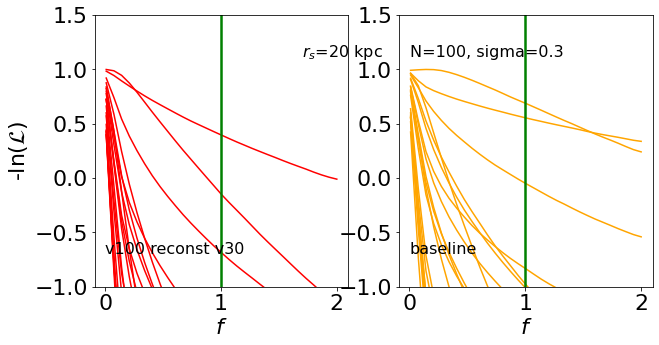

In [71]:
nBDs     = 100; sigma= 0.3
f        = 1.; gamma = 1.4; rs = 20.


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
     
    
axes[0].set_xlabel(r"$f$"); axes[1].set_xlabel(r"$f$")

smooth=0.8

for i in range(20):
    rank = i + 3
    filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/fixedT10v100reconstv30/N%isigma%.1f/" 
                %(nBDs, sigma))
    _file    = open(filepath + ("like_fixedT10v100reconstv30_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs, sigma, gamma, rs, rank)), "rb") 
    like     = pickle.load(_file)
    filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/fixedT10v100reconstv30/N%isigma%.1f/" 
                %(nBDs, sigma))
    _file    = open(filepath + ("posterior_fixedT10v100reconstv30_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs, sigma, gamma, rs, rank)), "rb") 
    samples  = pickle.load(_file)
    bin_n=30
    x = binned_statistic(samples[:, 0], like, 'max', bins=bin_n)[1] 
    y = binned_statistic(samples[:, 0], like, 'max', bins=bin_n+1)[0]
    y = y - np.max(y[~np.isnan(y)]) + 1
    axes[0].plot(x, gaussian_filter1d(y, sigma=smooth), ls="-", color="r")
    
    filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/fixedT10/N%isigma%.1f/" 
                %(nBDs, sigma))
    _file    = open(filepath + ("like_fixedT10v100_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs, sigma, gamma, rs, rank)), "rb") 
    like     = pickle.load(_file)
    filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/fixedT10/N%isigma%.1f/" 
                %(nBDs, sigma))
    _file    = open(filepath + ("posterior_fixedT10v100_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs, sigma, gamma, rs, rank)), "rb") 
    samples  = pickle.load(_file)
    bin_n=30
    x = binned_statistic(samples[:, 0], like, 'max', bins=bin_n)[1] 
    y = binned_statistic(samples[:, 0], like, 'max', bins=bin_n+1)[0]
    y = y - np.max(y[~np.isnan(y)]) + 1
    axes[1].plot(x, gaussian_filter1d(y, sigma=smooth), ls="-", color="orange")

    
axes[0].set_ylim(-1, 1.5); axes[1].set_ylim(-1, 1.5)

axes[0].text(1.7, 1.12, "$r_s$=%i kpc"%int(rs), fontsize=16)
axes[1].text(0.001, 1.12, "N=%i, sigma=%.1f"%(nBDs, sigma), fontsize=16)

axes[0].text(0.001, -0.7, "v100 reconst v30", fontsize=16)
axes[1].text(0.001, -0.7, "baseline", fontsize=16)
axes[0].set_ylabel(r"-ln($\mathcal{L}$)")
    
axes[0].axvline(f, color="green", lw=2.5); axes[1].axvline(f, color="green", lw=2.5)

fig.savefig("fixedT10v100_fixedT10v100reconstv30_likelihood_f_nBDs%i_sigma%.1i_gamma%.1frs%.1f.png"%(nBDs, sigma, gamma, rs), 
            bbox_inches="tight")

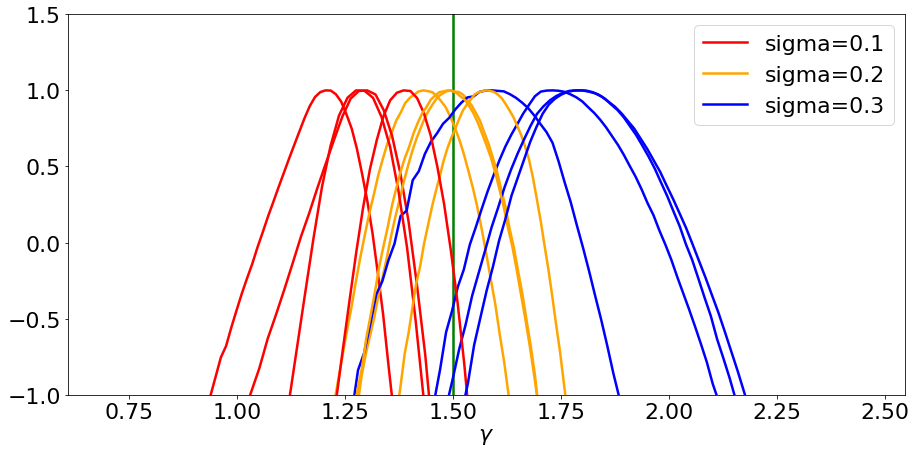

In [65]:
nBDs     = 1000; 
f        = 1.; gamma = 1.5; rs = 5.
rank= 97

fig, axes = plt.subplots(1, 1, figsize=(15, 7))
     
axes.axvline(gamma, color="g", ls="-", lw=2.5)
axes.set_xlabel(r"$\gamma$")

sigma= 0.1
filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/fixedT10Tcut650/N%isigma%.1f/" 
            %(nBDs, sigma))
_file    = open(filepath + ("like_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                            %(nBDs, sigma, gamma, rs, rank)), "rb") 
like     = pickle.load(_file)
filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/fixedT10Tcut650/N%isigma%.1f/" 
            %(nBDs, sigma))
_file    = open(filepath + ("posterior_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                            %(nBDs, sigma, gamma, rs, rank)), "rb") 
samples  = pickle.load(_file)
bin_n=80
x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y[~np.isnan(y)]) + 1
axes.plot(x, y, ls="-", color="r", lw=2.5, label="sigma=%.1f" %sigma)
#axes.axvline(samples[:, 1][np.argmax(like)], color="red", ls="--")

sigma=0.2
filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/fixedT10Tcut650/N%isigma%.1f/" 
        %(nBDs, sigma))
_file    = open(filepath + ("like_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                            %(nBDs, sigma, gamma, rs, rank)), "rb") 
like     = pickle.load(_file)
filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/fixedT10Tcut650/N%isigma%.1f/" 
            %(nBDs, sigma))
_file    = open(filepath + ("posterior_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                            %(nBDs, sigma, gamma, rs, rank)), "rb") 
samples  = pickle.load(_file)
bin_n=80
x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y[~np.isnan(y)]) + 1
axes.plot(x, y, ls="-", color="orange", lw=2.5, label="sigma=%.1f" %sigma)
#axes.axvline(samples[:, 1][np.argmax(like)], color="orange", ls="--") 

sigma=0.3
filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/fixedT10Tcut650/N%isigma%.1f/" 
        %(nBDs, sigma))
_file    = open(filepath + ("like_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                            %(nBDs, sigma, gamma, rs, rank)), "rb") 
like     = pickle.load(_file)
filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/fixedT10Tcut650/N%isigma%.1f/" 
            %(nBDs, sigma))
_file    = open(filepath + ("posterior_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                            %(nBDs, sigma, gamma, rs, rank)), "rb") 
samples  = pickle.load(_file)
bin_n=80
x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y[~np.isnan(y)]) + 1
axes.plot(x, y, ls="-", color="blue", lw=2.5, label="sigma=%.1f" %sigma)
#axes.axvline(samples[:, 1][np.argmax(like)], color="blue", ls="--") 


for rank in range(3):
    sigma= 0.1
    filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/fixedT10Tcut650/N%isigma%.1f/" 
                %(nBDs, sigma))
    _file    = open(filepath + ("like_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs, sigma, gamma, rs, rank+1)), "rb") 
    like     = pickle.load(_file)
    filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/fixedT10Tcut650/N%isigma%.1f/" 
                %(nBDs, sigma))
    _file    = open(filepath + ("posterior_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs, sigma, gamma, rs, rank+1)), "rb") 
    samples  = pickle.load(_file)
    bin_n=40
    x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
    y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
    y = y - np.max(y[~np.isnan(y)]) + 1
    axes.plot(x, y, ls="-", color="r", lw=2.5)
    #axes.axvline(samples[:, 1][np.argmax(like)], color="red", ls="--")

    sigma=0.2
    filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/fixedT10Tcut650/N%isigma%.1f/" 
            %(nBDs, sigma))
    _file    = open(filepath + ("like_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs, sigma, gamma, rs, rank+1)), "rb") 
    like     = pickle.load(_file)
    filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/fixedT10Tcut650/N%isigma%.1f/" 
                %(nBDs, sigma))
    _file    = open(filepath + ("posterior_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs, sigma, gamma, rs, rank+1)), "rb") 
    samples  = pickle.load(_file)
    bin_n=80
    x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
    y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
    y = y - np.max(y[~np.isnan(y)]) + 1
    axes.plot(x, y, ls="-", color="orange", lw=2.5)
    #axes.axvline(samples[:, 1][np.argmax(like)], color="orange", ls="--") 
    
    sigma=0.3
    filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/fixedT10Tcut650/N%isigma%.1f/" 
            %(nBDs, sigma))
    _file    = open(filepath + ("like_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs, sigma, gamma, rs, rank+1)), "rb") 
    like     = pickle.load(_file)
    filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/fixedT10Tcut650/N%isigma%.1f/" 
                %(nBDs, sigma))
    _file    = open(filepath + ("posterior_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs, sigma, gamma, rs, rank+1)), "rb") 
    samples  = pickle.load(_file)
    bin_n=80
    x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
    y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
    y = y - np.max(y[~np.isnan(y)]) + 1
    axes.plot(x, y, ls="-", color="blue", lw=2.5)
    #axes.axvline(samples[:, 1][np.argmax(like)], color="blue", ls="--") 
    
axes.set_ylim(-1, 1.5)
axes.legend()
#axes.set_xlim([0.8, 1.5])
    
fig.savefig("fixedT10v100Tcut650_like_gamma_gamma%.1frs%.1f.pdf" %(gamma, rs), bbox_inches="tight")

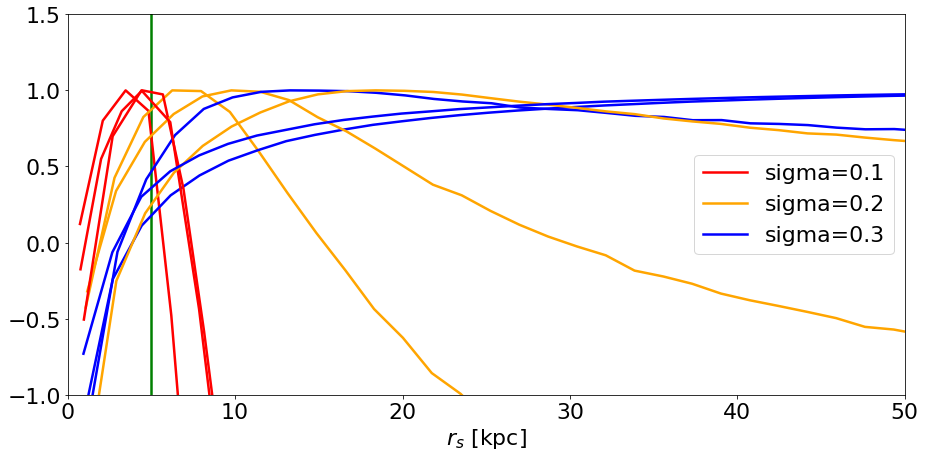

In [234]:
nBDs     = 1000; 
f        = 1.; gamma = 1.5; rs = 5.
rank= 97

fig, axes = plt.subplots(1, 1, figsize=(15, 7))
     
axes.axvline(rs, color="g", ls="-", lw=2.5)
axes.set_xlabel(r"$r_s$ [kpc]")

sigma= 0.1
filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/fixedT10Tcut650/N%isigma%.1f/" 
            %(nBDs, sigma))
_file    = open(filepath + ("like_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                            %(nBDs, sigma, gamma, rs, rank)), "rb") 
like     = pickle.load(_file)
filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/fixedT10Tcut650/N%isigma%.1f/" 
            %(nBDs, sigma))
_file    = open(filepath + ("posterior_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                            %(nBDs, sigma, gamma, rs, rank)), "rb") 
samples  = pickle.load(_file)
bin_n=40
x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y[~np.isnan(y)]) + 1
axes.plot(x, y, ls="-", color="r", lw=2.5, label="sigma=%.1f" %sigma)
#axes.axvline(samples[:, 1][np.argmax(like)], color="red", ls="--")

sigma=0.2
filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/fixedT10Tcut650/N%isigma%.1f/" 
        %(nBDs, sigma))
_file    = open(filepath + ("like_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                            %(nBDs, sigma, gamma, rs, rank)), "rb") 
like     = pickle.load(_file)
filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/fixedT10Tcut650/N%isigma%.1f/" 
            %(nBDs, sigma))
_file    = open(filepath + ("posterior_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                            %(nBDs, sigma, gamma, rs, rank)), "rb") 
samples  = pickle.load(_file)
bin_n=40
x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y[~np.isnan(y)]) + 1
axes.plot(x, y, ls="-", color="orange", lw=2.5, label="sigma=%.1f" %sigma)
#axes.axvline(samples[:, 1][np.argmax(like)], color="orange", ls="--") 

sigma=0.3
filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/fixedT10Tcut650/N%isigma%.1f/" 
        %(nBDs, sigma))
_file    = open(filepath + ("like_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                            %(nBDs, sigma, gamma, rs, rank)), "rb") 
like     = pickle.load(_file)
filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/fixedT10Tcut650/N%isigma%.1f/" 
            %(nBDs, sigma))
_file    = open(filepath + ("posterior_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                            %(nBDs, sigma, gamma, rs, rank)), "rb") 
samples  = pickle.load(_file)
bin_n=40
x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y[~np.isnan(y)]) + 1
axes.plot(x, y, ls="-", color="blue", lw=2.5, label="sigma=%.1f" %sigma)
#axes.axvline(samples[:, 1][np.argmax(like)], color="blue", ls="--") 


for rank in range(2):
    sigma= 0.1
    filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/fixedT10Tcut650/N%isigma%.1f/" 
                %(nBDs, sigma))
    _file    = open(filepath + ("like_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs, sigma, gamma, rs, rank+1)), "rb") 
    like     = pickle.load(_file)
    filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/fixedT10Tcut650/N%isigma%.1f/" 
                %(nBDs, sigma))
    _file    = open(filepath + ("posterior_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs, sigma, gamma, rs, rank+1)), "rb") 
    samples  = pickle.load(_file)
    bin_n=40
    x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
    y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]
    y = y - np.max(y[~np.isnan(y)]) + 1
    axes.plot(x, y, ls="-", color="r", lw=2.5)
    #axes.axvline(samples[:, 1][np.argmax(like)], color="red", ls="--")

    sigma=0.2
    filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/fixedT10Tcut650/N%isigma%.1f/" 
            %(nBDs, sigma))
    _file    = open(filepath + ("like_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs, sigma, gamma, rs, rank+1)), "rb") 
    like     = pickle.load(_file)
    filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/fixedT10Tcut650/N%isigma%.1f/" 
                %(nBDs, sigma))
    _file    = open(filepath + ("posterior_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs, sigma, gamma, rs, rank+1)), "rb") 
    samples  = pickle.load(_file)
    bin_n=40
    x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
    y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]
    y = y - np.max(y[~np.isnan(y)]) + 1
    axes.plot(x, y, ls="-", color="orange", lw=2.5)
    #axes.axvline(samples[:, 1][np.argmax(like)], color="orange", ls="--") 
    
    sigma=0.3
    filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/fixedT10Tcut650/N%isigma%.1f/" 
            %(nBDs, sigma))
    _file    = open(filepath + ("like_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs, sigma, gamma, rs, rank+1)), "rb") 
    like     = pickle.load(_file)
    filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/fixedT10Tcut650/N%isigma%.1f/" 
                %(nBDs, sigma))
    _file    = open(filepath + ("posterior_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv%i" 
                                %(nBDs, sigma, gamma, rs, rank+1)), "rb") 
    samples  = pickle.load(_file)
    bin_n=40
    x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
    y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]
    y = y - np.max(y[~np.isnan(y)]) + 1
    axes.plot(x, y, ls="-", color="blue", lw=2.5)
    #axes.axvline(samples[:, 1][np.argmax(like)], color="blue", ls="--") 
    
axes.set_ylim(-1, 1.5)
axes.legend()
axes.set_xlim([0., 50.])
    
fig.savefig("fixedT10v100Tcut650_like_rs_gamma%.1frs%.1f.pdf" %(gamma, rs), bbox_inches="tight")

In [85]:
def LI(L, samples, bin_n=80, verbose=False, _niteration=30):                                       
    """                                                                            
    For each parameter, construct profile likelihood and return the profile likelihood interval
    (i.e. region where the log Likelihood is within 1 of its maximum value)        
                                                                                   
    """                                                                            
    # Create bins in Likelihood vs parameter space, find the max Likelihood     
    # value in each bin and the corresponding parameter values                     
    x = binned_statistic(samples, -L, 'min', bins=bin_n)[1]                        
    y = binned_statistic(samples, -L, 'min', bins=bin_n+1)[0]   
                                                                                   
    # Create Interpolation fanction Likelihood - parameter                         
    #pdb.set_trace()                                                               
    z =  UnivariateSpline(x[~np.isnan(y)], y[~np.isnan(y)], s=0)                                               
                                                                                   
    # Find in which points crosses 1sigma horizontal line (where 1 sigma           
    # corresponds to 1/2 -for 1 dof-)                                              
    x_tmin     = np.min(samples)                                                   
    epsilon    = 1                                                                 
    niteration = 0                                                                 
    logLmin    = np.min(y[~np.isnan(y)]) + 1.                                                   
    while epsilon > 10**-6 and niteration < _niteration:                                    
        niteration +=1                                                             
        minimum = minimize(lambda x: (z(x)-logLmin)**2, x_tmin,                    
                           bounds=((np.min(samples), samples[np.argmax(L)]),))  
        epsilon = minimum.fun                                                      
        x_tmin  = x_tmin*1.1                                                       
        _min    = minimum.x                                                        
                                                                                   
    if epsilon < 10**-6:                                                           
        LImin = _min[0]                                                            
    else:                                                                          
        LImin = np.min(samples)                                                    
                                                                                   
    x_tmax     = samples[np.argmax(L)]                                             
    epsilon    = 1                                                                 
    niteration = 0                                                                 
    while epsilon > 10**-6 and niteration < _niteration:                                    
        niteration +=1                                                             
        maximum = minimize(lambda x: (z(x)-logLmin)**2, x_tmax,                    
                           bounds=((samples[np.argmax(L)], np.max(samples)),))  
        epsilon  = maximum.fun                                                     
        x_tmax  = x_tmax*1.1                                                       
        _max    = maximum.x                                                        
                                                                                   
    if epsilon < 10**-6:                                                           
        LImax = _max[0]                                                            
    else:   
        print("here", epsilon, _max)
        LImax = np.max(samples)                                                    
                                                                                   
    if verbose==True:   
        print(LImin, LImax)
        fig, ax = plt.subplots(1, 1, figsize=(7, 7))                               
        ax.plot(x, y, color="k", lw=2.5)                                           
        ax.axvline(LImin, color="g"); ax.axvline(LImax, color="g")
        ax.set_ylim(np.min(y[~np.isnan(y)])-1, np.min(y[~np.isnan(y)]) + 1.1)
        ax.axhline(np.min(y[~np.isnan(y)]) + 1)
        #ax.set_xlim(0, 0.25)
        #print(np.min(y[~np.isnan(y)]), x)
                                                                                   
    #Return                                                                        
    return  LImin, LImax

In [86]:
nBDs     = 1000; sigma= 0.2
f        = 1.; gamma = 0.6; rs = 20.

filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/fixedT10Tcut650_nocutTwn/N%isigma%.1fb/" 
            %(nBDs, sigma))
_file    = open(filepath + ("like_fixedT10v100Tcut650_nocutTwn_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv3" 
                            %(nBDs, sigma, gamma, rs)), "rb") 
like     = pickle.load(_file)
filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/fixedT10Tcut650_nocutTwn/N%isigma%.1fb/" 
            %(nBDs, sigma))
_file    = open(filepath + ("posterior_fixedT10v100Tcut650_nocutTwn_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv3" 
                            %(nBDs, sigma, gamma, rs)), "rb") 
samples  = pickle.load(_file)

7.098990570497676e-06 0.5623033296855531


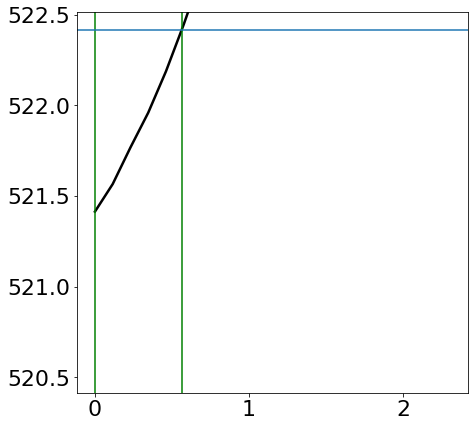

In [87]:
from scipy.interpolate import UnivariateSpline
from scipy.optimize import minimize
#LI(like, samples[:, 2], bin_n=20, verbose=True, niteration=30)

_, _ = LI(like, samples[:, 1], bin_n=20, verbose=True, _niteration=20)

#_, _ = LI(like, samples[:, 1], bin_n=80, verbose=True, _niteration=25)

In [3]:
#path = "/home/mariacst/exoplanets/results/velocity/v100/fixedT10Tcut650/"
#ex   = "fixedT10v100Tcut650"
#path = "/home/mariacst/exoplanets/results/velocity/v100/fixedT10Tcut650_nocutTwn/"
#ex   = "fixedT10v100Tcut650_nocutTwn"
path = "/home/mariacst/exoplanets/results/velocity/v100/fixedT10v100/"
ex   = "fixedT10v100"
#path = "/home/mariacst/exoplanets/results/velocity/v30/fixedT10v30/"
#ex   = "fixedT10v30"
#path = "/home/mariacst/exoplanets/results/velocity/v100/fixedT10v100reconstv30/"
#ex   = "fixedT10v100reconstv30"
#path = "/home/mariacst/exoplanets/results/velocity/v100/priorsRC/"
#ex   = "priorsRC"

In [45]:
# ploting priors
import pandas as pd

def compute_density_levels(H, levels=(1-np.exp(-0.5), 1-np.exp(-2), 1-np.exp(-4.5))):
    # Compute the density levels.
    Hflat = H.flatten()
    inds = np.argsort(Hflat)[::-1]
    Hflat = Hflat[inds]
    sm = np.cumsum(Hflat)
    sm /= sm[-1]
    V = np.empty(len(levels))
    for i, v0 in enumerate(levels):
        try:
            V[i] = Hflat[sm <= v0][-1]
        except:
            V[i] = Hflat[0]
    V.sort()
    m = np.diff(V) == 0
    if np.any(m) and not quiet:
        logging.warning("Too few points to create valid contours")
    while np.any(m):
        V[np.where(m)[0][0]] *= 1.0 - 1e-4
        m = np.diff(V) == 0
    V.sort()
    return V

data = np.genfromtxt("/home/mariacst/exoplanets/exoplanets/data/posterior_gNFW.dat", unpack=True)
post = pd.DataFrame()

post["gamma"] = data[0]
post["rs"]    = data[1]
post["p"]     = data[4]

gamma_values = post.gamma.unique()
rs_values    = post.rs.unique()

prior = np.ones((len(gamma_values), len(rs_values)))                               
for i in range(len(gamma_values)):                                                 
    for j in range(len(rs_values)):                                                
        prior[i, j] = post[(post.rs==rs_values[j]) &                               
                           (post.gamma==gamma_values[i])].p.max()  

V = compute_density_levels(prior)

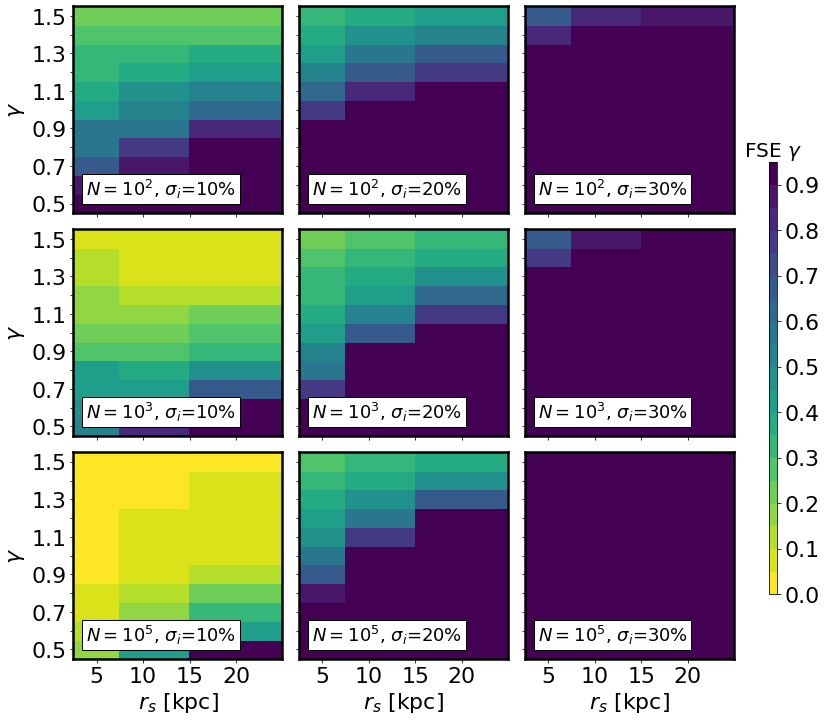

In [15]:
#fig, ax = plt.subplots(2, 3, figsize=(12, 8))
fig, ax = plt.subplots(3, 3, figsize=(12, 12))

PE     = "ML"
priors = False
im   = grid_FSE_all(path, 100, 0.1, ex, ax[0, 0], PE, False, True, True, False)
im   = grid_FSE_all(path, 1000, 0.1, ex, ax[1, 0], PE, False, True, True, False)
im   = grid_FSE_all(path, 100000, 0.1, ex, ax[2, 0], PE, False, True, True, True)

im   = grid_FSE_all(path, 100, 0.2, ex, ax[0, 1], PE, False, True, False, False, show=False)
im   = grid_FSE_all(path, 1000, 0.2, ex, ax[1, 1], PE, False, True, False, False)
im   = grid_FSE_all(path, 100000, 0.2, ex, ax[2, 1], PE, False, True, False, True)

im   = grid_FSE_all(path, 100, 0.3, ex, ax[0, 2], PE, False, True, False, False)
im   = grid_FSE_all(path, 1000, 0.3, ex, ax[1, 2], PE, False, True, False, False)
im   = grid_FSE_all(path, 100000, 0.3, ex, ax[2, 2], PE, False, True, False, True)

if priors==True:
    from scipy.ndimage import gaussian_filter
    x, y = np.meshgrid(gamma_values, rs_values, indexing="ij")
    ax[0, 0].contour(y, x, gaussian_filter(prior, 2.), V, linewidths=3.5, colors="#e91e63")

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $\gamma$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

fig.savefig(ex + "_FSE_" + PE + "_gamma.png", bbox_inches="tight")

In [14]:
norm = colors.BoundaryNorm(boundaries=np.arange(0, 1, 0.05), ncolors=256)
norm.boundaries

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [42]:
def FSE(filepath, nBDs, sigma, _g, _rs, PE, ex, FSE_f=False, FSE_g=True, FSE_rs=False, f=1):
    data = np.genfromtxt(filepath + "statistics_" + ex +                
                                 ("_N%i_sigma%.1f_f%.1fgamma%.1frs%.1f"             
                                  %(nBDs, sigma, f, _g, _rs)), unpack=True) 
    rank=100.
    if PE=="median":                                                        
        pe = np.array((data[3], data[4], data[5]))                          
    elif PE=="mode":                                                        
        pe = np.array((data[12], data[13], data[14]))                       
    elif PE=="mean":                                                        
        pe = np.array((data[0], data[1], data[2]))                          
    elif PE=="ML":                                                          
        pe = np.array((data[15], data[16], data[17]))                       
    else:                                                                   
        sys.exit("Point estimate not implemented!")     
    if FSE_f==True:
        return np.sqrt(1/rank*np.sum(np.power(pe[0] - f, 2)))/f
    elif FSE_g==True:
        return np.sqrt(1/rank*np.sum(np.power(pe[1] - _g, 2)))/_g
    elif FSE_rs==True:
        return np.sqrt(1/rank*np.sum(np.power(pe[2] - _rs, 2)))/_rs
    
    
path = "/home/mariacst/exoplanets/results/velocity/v100/priorsRC/"
ex   = "priorsRC"
print(FSE(path, 100, 0.2, 1.5, 10., "median", ex))
print(FSE(path, 100, 0.2, 1.5, 20., "median", ex))

0.03385526711031995
0.06500618397933812


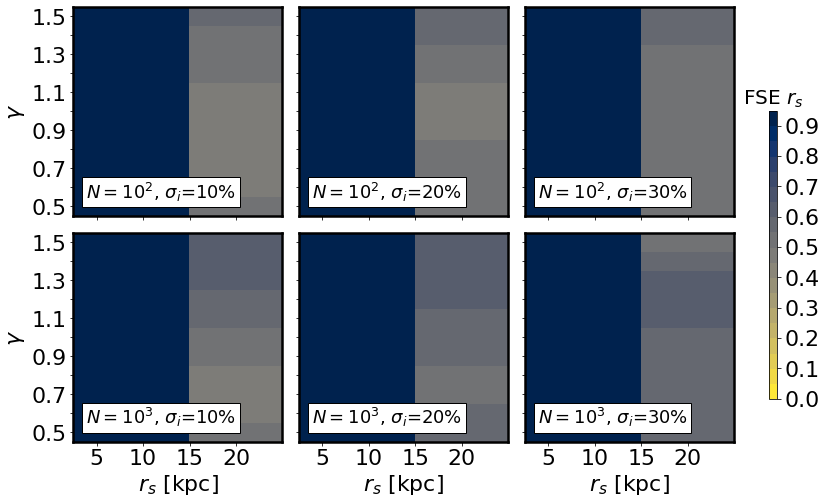

In [49]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

im   = grid_FSE_all(path, 100, 0.1, ex, ax[0, 0], PE, False, False, True, False)
im   = grid_FSE_all(path, 1000, 0.1, ex, ax[1, 0], PE, False, False, True, True, show=False)
#im   = grid_FSE_all_1e5(path, 100000, 0.1, "fixedT100K", ax[2, 0], PE, False, False, True, True)

im   = grid_FSE_all(path, 100, 0.2, ex, ax[0, 1], PE, False, False, False, False)
im   = grid_FSE_all(path, 1000, 0.2, ex, ax[1, 1], PE, False, False, False, True, show=False)
#im   = grid_FSE_all_1e5(path, 100000, 0.2, "fixedT100K", ax[2, 1], PE, False, False, False, True)

im   = grid_FSE_all(path, 100, 0.3, ex, ax[0, 2], PE, False, False, False, False)
im   = grid_FSE_all(path, 1000, 0.3, ex, ax[1, 2], PE, False, False, False, True)
#im   = grid_FSE_all_1e5(path, 100000, 0.3, "fixedT100K", ax[2, 2], PE, False, False, False, True)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $r_s$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

fig.savefig(ex + "_FSE_" + PE + "_rs.png", bbox_inches="tight")

**Coverage**

In [50]:
import utils_plots_up
import imp
imp.reload(utils_plots_up)
from utils_plots_up import coverage_all, grid_coverage_all

plt.rc('font', family='serif',size=22)

OSError: /home/mariacst/exoplanets/results/velocity/v100/fixedT10Tcut650/statistics_fixedT10v100Tcut650_N100_sigma0.2_f1.0gamma1.1rs20.0 not found.

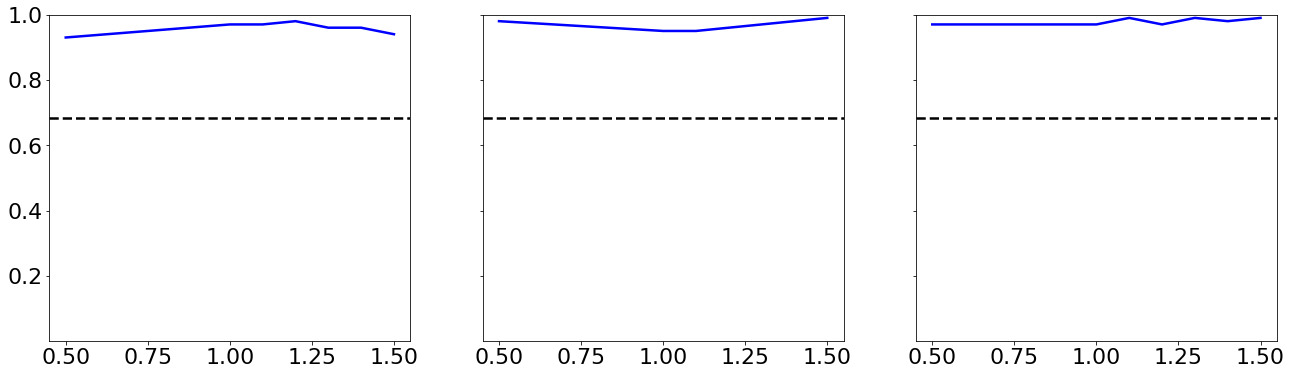

In [29]:
nBDs    = 100.
rel_unc = [0.1, 0.2, 0.3]
CR      = "symmetric"

color=["blue", "orange", "green"]

fig, ax = plt.subplots(1, 3, figsize=(22, 6), sharey=True)
ax[0].set_ylim(0.001, 1); ax[0].set_xlim(0.45, 1.55)
ax[1].set_xlim(0.45, 1.55); ax[2].set_xlim(0.45, 1.55)
ax[0].axhline(0.683, color="k", ls="--", lw=2.5); ax[1].axhline(0.683, color="k", ls="--", lw=2.5); ax[2].axhline(0.683, color="k", ls="--", lw=2.5)

x = [0.5, 1., 1.1, 1.2, 1.3, 1.4, 1.5]

i=0
for rel in rel_unc:
    cove1_rs5, cove2_rs5, cove3_rs5    = coverage_all(path, nBDs, rel, ex, 5., CR=CR)
    cove1_rs10, cove2_rs10, cove3_rs10 = coverage_all(path, nBDs, rel, ex, 10., CR=CR)
    cove1_rs20, cove2_rs20, cove3_rs20 = coverage_all(path, nBDs, rel, ex, 20., CR=CR)
    
    ax[0].plot(x, np.asarray(cove1_rs5)/100., color=color[i], lw=2.5)
    ax[1].plot(x, np.asarray(cove1_rs10)/100., color=color[i], lw=2.5)
    ax[2].plot(x, np.asarray(cove1_rs20)/100., color=color[i], lw=2.5, 
               label=("nBDs=%i, $\sigma=%.1f$" %(nBDs, rel)))
    i+=1
    
ax[0].set_ylim(0.001, 1); ax[0].set_xlim(0.45, 1.55)
ax[1].set_xlim(0.45, 1.55); ax[2].set_xlim(0.45, 1.55)
ax[0].axhline(0.683, color="k", ls="--", lw=2.5); ax[1].axhline(0.683, color="k", ls="--", lw=2.5); ax[2].axhline(0.683, color="k", ls="--", lw=2.5)

nBDs=1000
i=0
for rel in rel_unc:
    cove1_rs5, cove2_rs5, cove3_rs5    = coverage_all(path, nBDs, rel, ex, 5., CR=CR)
    cove1_rs10, cove2_rs10, cove3_rs10 = coverage_all(path, nBDs, rel, ex, 10., CR=CR)
    cove1_rs20, cove2_rs20, cove3_rs20 = coverage_all(path, nBDs, rel, ex, 20., CR=CR)
    
    ax[0].plot(x, np.asarray(cove1_rs5)/100., color=color[i], lw=2.5, ls="--")
    ax[1].plot(x, np.asarray(cove1_rs10)/100., color=color[i], lw=2.5, ls="--")
    ax[2].plot(x, np.asarray(cove1_rs20)/100., color=color[i], lw=2.5, ls="--")
    i+=1

ax[2].legend(frameon=False)
ax[0].set_ylabel("Coverage")

plt.subplots_adjust(wspace=0.04)

../python/utils_plots_up.py:1085: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(xi, yi, zi_2, norm=norm, cmap=cmap)
../python/utils_plots_up.py:1096: UserWarning: The following kwargs were not used by contour: 'color'
  CS = ax.contour(xi_c, yi_c, zi_c.reshape(5, 13), levels=[0.68, 1.], color="k")
../python/utils_plots_up.py:1115: UserWarning: FixedFormatter should only be used together with FixedLocator
  '', '1.5'])
../python/utils_plots_up.py:1120: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5', '10', '15', '20'])
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


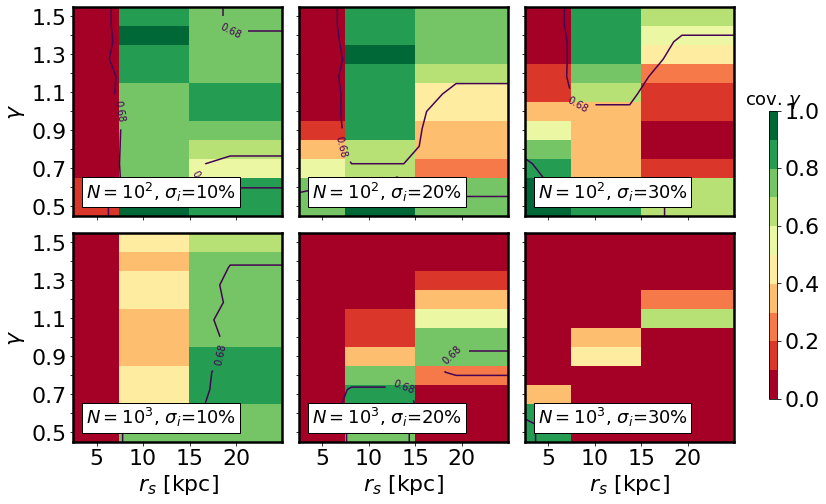

In [51]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

CR   = "symmetric"
im   = grid_coverage_all(path, 100, 0.1, ex, ax[0, 0], CR, False, True, True, False)
im   = grid_coverage_all(path, 1000, 0.1, ex, ax[1, 0], CR, False, True, True, True)
#im   = grid_coverage_all_1e5(path, 100000, 0.1, "fixedT100K", ax[2, 0], CR, False, True, True, True)

im   = grid_coverage_all(path, 100, 0.2, ex, ax[0, 1], CR, False, True, False, False)
im   = grid_coverage_all(path, 1000, 0.2, ex, ax[1, 1], CR, False, True, False, True)
#im   = grid_coverage_all_1e5(path, 100000, 0.2, "fixedT100K", ax[2, 1], CR, False, True, False, True)

im   = grid_coverage_all(path, 100, 0.3, ex, ax[0, 2], CR, False, True, False, False)
im   = grid_coverage_all(path, 1000, 0.3, ex, ax[1, 2],CR, False, True, False, True)
#im   = grid_coverage_all_1e5(path, 100000, 0.3, "fixedT100K", ax[2, 2], CR, False, True, False, True)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"cov. $\gamma$", size=18.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

fig.savefig(ex + "_coverage_" + CR + "_gamma.png", bbox_inches="tight")

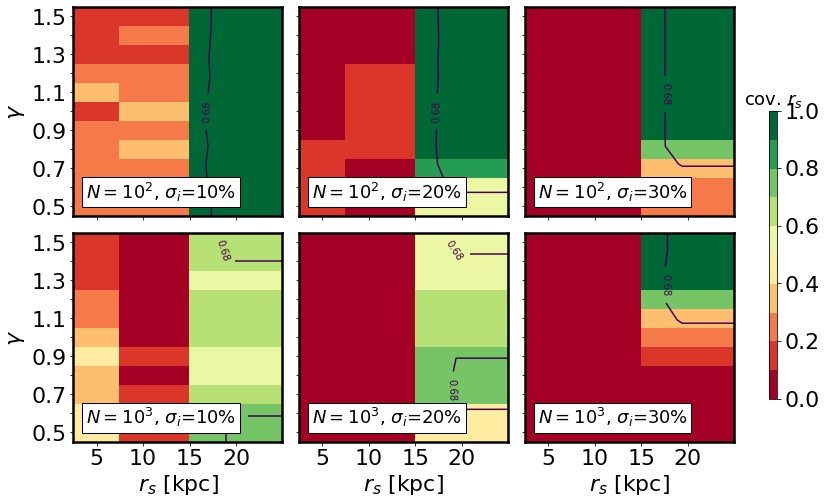

In [82]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

im   = grid_coverage_all(path, 100, 0.1, ex, ax[0, 0], CR, False, False, True, False)
im   = grid_coverage_all(path, 1000, 0.1, ex, ax[1, 0], CR, False, False, True, True)
#im   = grid_coverage_all_1e5(path, 100000, 0.1, "fixedT100K", ax[2, 0], CR, False, True, True, True)

im   = grid_coverage_all(path, 100, 0.2, ex, ax[0, 1], CR, False, False, False, False)
im   = grid_coverage_all(path, 1000, 0.2, ex, ax[1, 1], CR, False, False, False, True)
#im   = grid_coverage_all_1e5(path, 100000, 0.2, "fixedT100K", ax[2, 1], CR, False, True, False, True)

im   = grid_coverage_all(path, 100, 0.3, ex, ax[0, 2], CR, False, False, False, False)
im   = grid_coverage_all(path, 1000, 0.3, ex, ax[1, 2],CR, False, False, False, True)
#im   = grid_coverage_all_1e5(path, 100000, 0.3, "fixedT100K", ax[2, 2], CR, False, True, False, True)


fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"cov. $r_s$", size=18.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

fig.savefig(ex + "_coverage_" + CR + "_rs.png", bbox_inches="tight")

## Fixed velocity DM particles to $v=100$ km/s & $\sigma_T=100$ K

../python/utils_plots.py:612: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0.5', '1', '', '1.2', '', '1.4', ''])
../python/utils_plots.py:617: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5', '10', '20'])


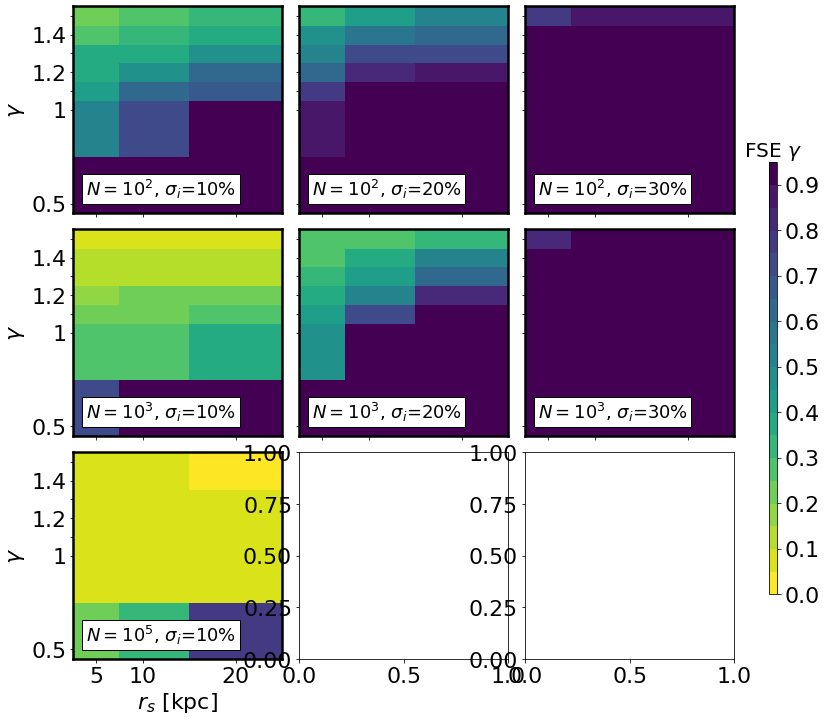

In [7]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))

path = "/home/mariacst/exoplanets/results/velocity/v100/fixedT100K/"
PE   = "ML"
ex   = "fixedT100K_nwalkers100"
im   = grid_FSE_all(path, 100, 0.1, ex, ax[0, 0], PE, False, True, True, False)
im   = grid_FSE_all(path, 1000, 0.1, ex, ax[1, 0], PE, False, True, True, False)
im   = grid_FSE_all_1e5(path, 100000, 0.1, "fixedT100K", ax[2, 0], PE, False, True, True, True, trick=False)

im   = grid_FSE_all(path, 100, 0.2, ex, ax[0, 1], PE, False, True, False, False)
im   = grid_FSE_all(path, 1000, 0.2, ex, ax[1, 1], PE, False, True, False, False)
#im   = grid_FSE_all_1e5(path, 100000, 0.2, "fixedT100K", ax[2, 1], PE, False, True, False, True)

im   = grid_FSE_all(path, 100, 0.3, ex, ax[0, 2], PE, False, True, False, False)
im   = grid_FSE_all(path, 1000, 0.3, ex, ax[1, 2], PE, False, True, False, False)
#im   = grid_FSE_all_1e5(path, 100000, 0.3, "fixedT100K", ax[2, 2], PE, False, True, False, True)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $\gamma$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

#fig.savefig("fixedT100K_nwalkers100_FSE_" + PE + "_gamma.pdf", bbox_inches="tight")

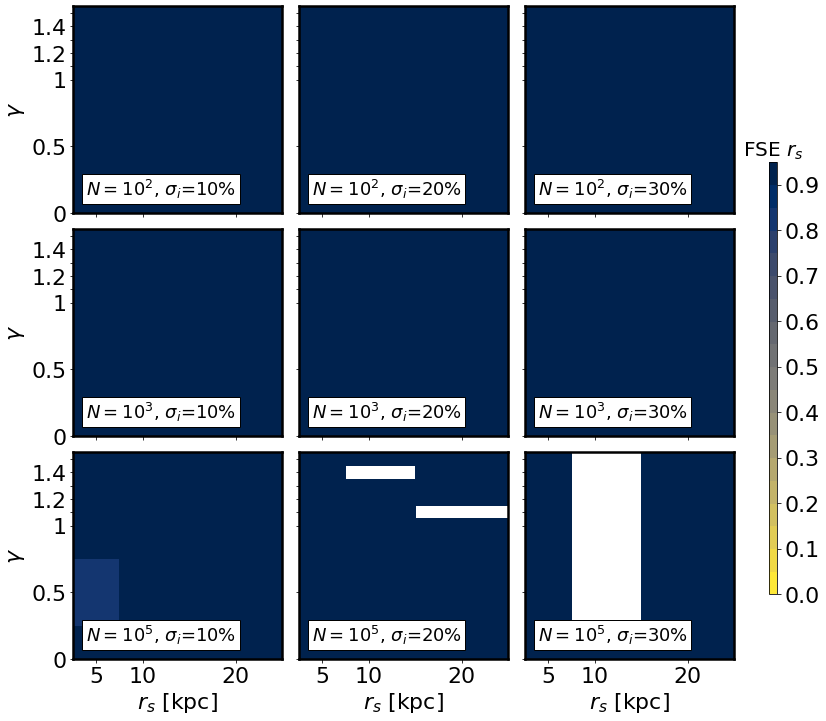

In [5]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))

path = "/home/mariacst/exoplanets/results/velocity/v100/fixedT100K/"
PE   = "ML"
ex   = "fixedT100K_nwalkers100"
im   = grid_FSE_all(path, 100, 0.1, ex, ax[0, 0], PE, False, False, True, False)
im   = grid_FSE_all(path, 1000, 0.1, ex, ax[1, 0], PE, False, False, True, False)
im   = grid_FSE_all_1e5(path, 100000, 0.1, "fixedT100K", ax[2, 0], PE, False, False, True, True)

im   = grid_FSE_all(path, 100, 0.2, ex, ax[0, 1], PE, False, False, False, False)
im   = grid_FSE_all(path, 1000, 0.2, ex, ax[1, 1], PE, False, False, False, False)
im   = grid_FSE_all_1e5(path, 100000, 0.2, "fixedT100K", ax[2, 1], PE, False, False, False, True)

im   = grid_FSE_all(path, 100, 0.3, ex, ax[0, 2], PE, False, False, False, False)
im   = grid_FSE_all(path, 1000, 0.3, ex, ax[1, 2], PE, False, False, False, False)
im   = grid_FSE_all_1e5(path, 100000, 0.3, "fixedT100K", ax[2, 2], PE, False, False, False, True)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"FSE $r_s$", size=20.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

#fig.savefig("fixedT100K_nwalkers100_FSE_" + PE + "_rs.pdf", bbox_inches="tight")

In [6]:
import imp
import utils_plots
imp.reload(utils_plots)
from utils_plots import grid_coverage_all_1e5

../python/utils_plots.py:1028: UserWarning: The following kwargs were not used by contour: 'color'
  CS = ax.contour(xi_c, yi_c, zi_c.reshape(5, 5), levels=[68, 100], color="k")
../python/utils_plots.py:1043: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '0.5', '1', '', '1.2', '', '1.4', ''])
../python/utils_plots.py:1114: UserWarning: The following kwargs were not used by contour: 'color'
  CS = ax.contour(xi_c, yi_c, zi_c.reshape(5, 5), levels=[68, 100], color="k")
../python/utils_plots.py:1129: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '0.5', '1', '', '1.2', '', '1.4', ''])
../python/utils_plots.py:1134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5', '10', '20'])
../python/utils_plots.py:1114: UserWarning: No contour levels were found within the data range.
  CS = ax.contour(xi_c, yi_c, zi_c.reshape(5, 5), levels=[

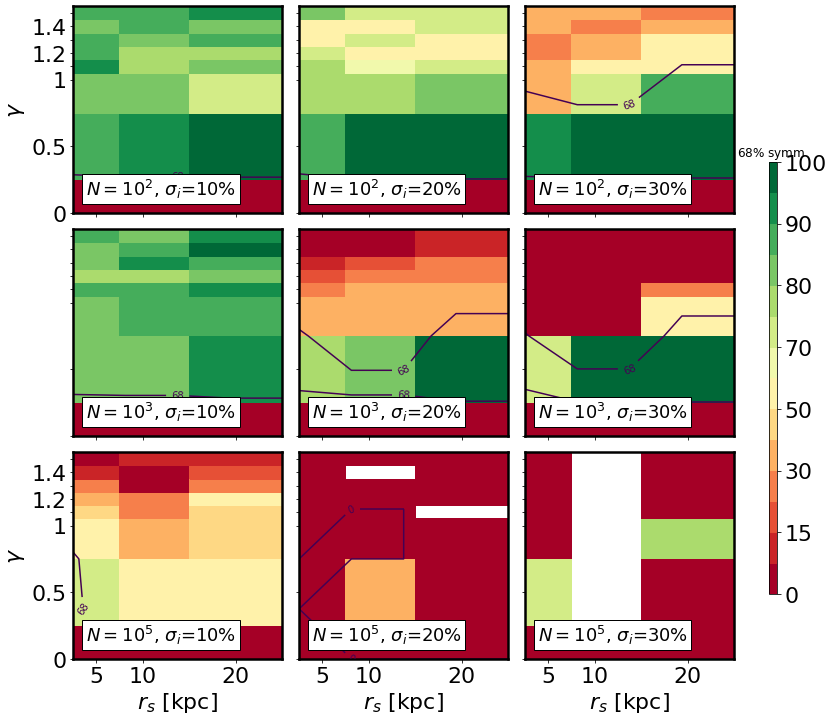

In [7]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))

path = "/home/mariacst/exoplanets/results/velocity/v100/fixedT100K/"
CR   = "LI"
ex   = "fixedT100K_nwalkers100"
im   = grid_coverage_all(path, 100, 0.1, ex, ax[0, 0], CR, False, True, True, False)
im   = grid_coverage_all(path, 1000, 0.1, ex, ax[1, 0], CR, False, True, False, False)
im   = grid_coverage_all_1e5(path, 100000, 0.1, "fixedT100K", ax[2, 0], CR, False, True, True, True)

im   = grid_coverage_all(path, 100, 0.2, ex, ax[0, 1], CR, False, True, False, False)
im   = grid_coverage_all(path, 1000, 0.2, ex, ax[1, 1], CR, False, True, False, False)
im   = grid_coverage_all_1e5(path, 100000, 0.2, "fixedT100K", ax[2, 1], CR, False, True, False, True)

im   = grid_coverage_all(path, 100, 0.3, ex, ax[0, 2], CR, False, True, False, False)
im   = grid_coverage_all(path, 1000, 0.3, ex, ax[1, 2],CR, False, True, False, False)
im   = grid_coverage_all_1e5(path, 100000, 0.3, "fixedT100K", ax[2, 2], CR, False, True, False, True)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"68$\%$ symm.", size=12.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

#fig.savefig("fixedT100K_nwalkers100_coverage_" + CR + "_gamma.pdf", bbox_inches="tight")

../python/utils_plots.py:1039: UserWarning: No contour levels were found within the data range.
  CS = ax.contour(xi_c, yi_c, zi_c.reshape(5, 5), levels=[68, 100], color="k")
../python/utils_plots.py:1039: UserWarning: The following kwargs were not used by contour: 'color'
  CS = ax.contour(xi_c, yi_c, zi_c.reshape(5, 5), levels=[68, 100], color="k")
../python/utils_plots.py:1125: UserWarning: The following kwargs were not used by contour: 'color'
  CS = ax.contour(xi_c, yi_c, zi_c.reshape(5, 5), levels=[68, 100], color="k")
../python/utils_plots.py:1125: UserWarning: No contour levels were found within the data range.
  CS = ax.contour(xi_c, yi_c, zi_c.reshape(5, 5), levels=[68, 100], color="k")


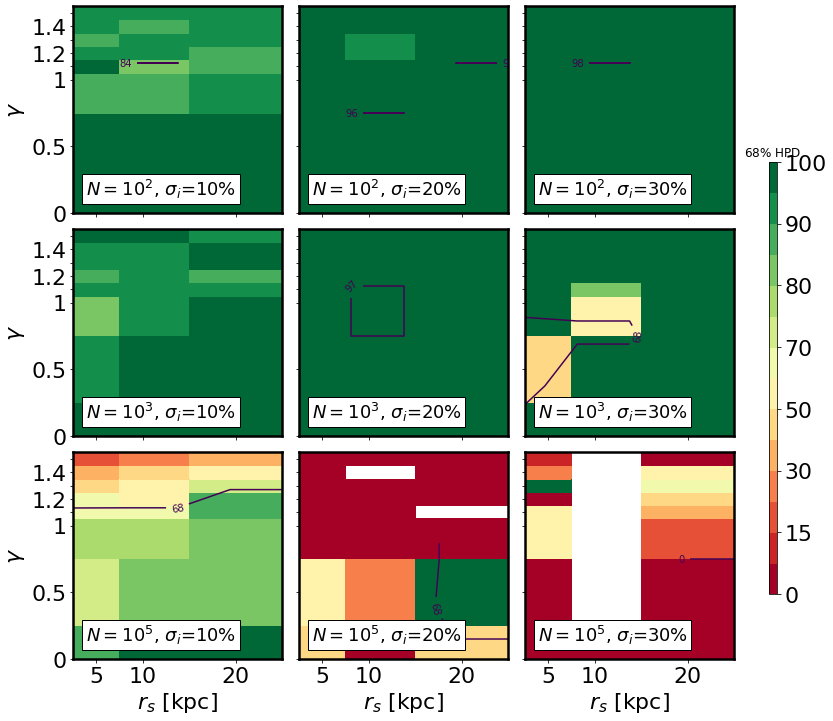

In [8]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))

path = "/home/mariacst/exoplanets/results/velocity/v100/fixedT100K/"
CR   = "LI"
ex   = "fixedT100K_nwalkers100"
im   = grid_coverage_all(path, 100, 0.1, ex, ax[0, 0], CR, False, False, True, False)
im   = grid_coverage_all(path, 1000, 0.1, ex, ax[1, 0],CR, False, False, True, False)
im   = grid_coverage_all_1e5(path, 100000, 0.1, "fixedT100K", ax[2, 0], CR, False, False, True, True)

im   = grid_coverage_all(path, 100, 0.2, ex, ax[0, 1], CR, False, False, False, False)
im   = grid_coverage_all(path, 1000, 0.2, ex, ax[1, 1],CR, False, False, False, False)
im   = grid_coverage_all_1e5(path, 100000, 0.2, "fixedT100K", ax[2, 1], CR, False, False, False, True)

im   = grid_coverage_all(path, 100, 0.3, ex, ax[0, 2], CR, False, False, False, False)
im   = grid_coverage_all(path, 1000, 0.3, ex, ax[1, 2],CR, False, False, False, False)
im   = grid_coverage_all_1e5(path, 100000, 0.3, "fixedT100K", ax[2, 2], CR, False, False, False, True)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title(r"68$\%$ HPD", size=12.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

#fig.savefig("fixedT100K_coverage_" + CR + "_rs.pdf", bbox_inches="tight")

## RC priors

In [58]:
import imp
import utils_plots
imp.reload(utils_plots)
from utils_plots import grid_FSE_all, grid_FSE_all_1e5, coverage_all

rc('font',**{'family':'serif','serif':['Palatino'], 'size':18})

In [57]:
path = "/home/mariacst/exoplanets/running/priorsRC/"
ex   = "priorsRC"

[-1.58733613 -0.43145258 -0.13125738  0.22524306  0.4987921   0.64616419
  0.86107652  1.          0.98584715]
5.87576245184292 39.124894311870534    -1.5873361313522665 1.0
0.302389069139111 1.7407861198330337    -4.921855558735992 1.0
0.11601796742292259 1.9999991276988234    -2.579722504480813 1.0


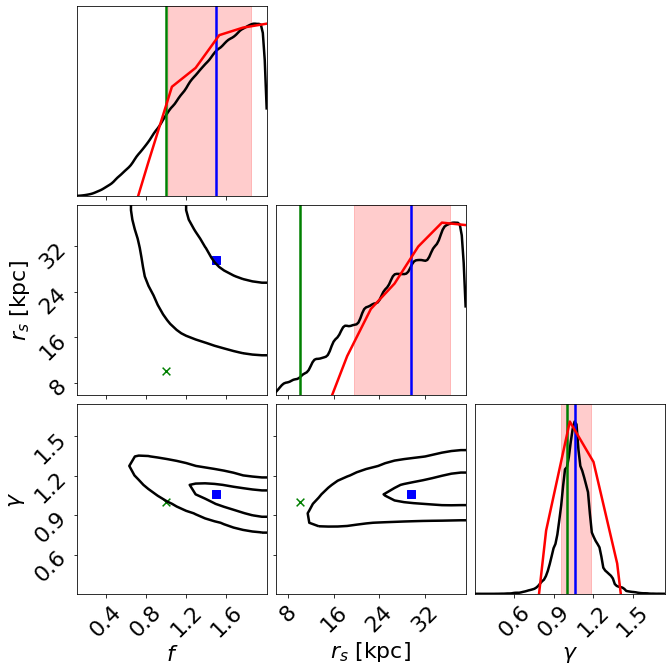

In [62]:
nBDs     = 100 ; sigma= 0.1
f        = 1.; gamma    = 1.; rs = 10.

_file    = open(path + ("like_priorsRC_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv1" %(nBDs, sigma, gamma, rs)), "rb") 
like     = pickle.load(_file)
_file    = open(path + ("posterior_priorsRC_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv1" %(nBDs, sigma, gamma, rs)), "rb") 
samples  = pickle.load(_file)

smooth=1.
fig, axes = corner(np.array([samples[:, 0], samples[:, 2], samples[:, 1]]).T, 
                   levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="k",)
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], np.array([samples[:, 0], samples[:, 2], samples[:, 1]])):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5)      
    
axes[0, 0].axvline(1., color="g", ls="-", lw=2.5); axes[0, 0].axvline(np.median(samples[:, 0]), color="b", ls="-", lw=2.5)
axes[1, 1].axvline(rs, color="g", ls="-", lw=2.5); axes[1, 1].axvline(np.median(samples[:, 2]), color="b", ls="-", lw=2.5)
axes[2, 2].axvline(gamma, color="g", ls="-", lw=2.5); axes[2, 2].axvline(np.median(samples[:, 1]), color="b", ls="-", lw=2.5)
axes[1, 0].scatter(f, rs, marker="x", color="g", s=60); axes[1, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 2]), marker="s", color="b", s=60)
axes[2, 0].scatter(f, gamma, marker="x", color="g", s=60); axes[2, 0].scatter(np.median(samples[:, 0]), np.median(samples[:, 1]), marker="s", color="b", s=60)
axes[2, 1].scatter(rs, gamma, marker="x", color="g", s=60); axes[2, 1].scatter(np.median(samples[:, 2]), np.median(samples[:, 1]), marker="s", color="b", s=60)

axes[0, 0].axvspan(np.percentile(samples[:, 0], 16), np.percentile(samples[:, 0], 84), color="red", alpha=0.2)
axes[1, 1].axvspan(np.percentile(samples[:, 2], 16), np.percentile(samples[:, 2], 84), color="red", alpha=0.2)
axes[2, 2].axvspan(np.percentile(samples[:, 1], 16), np.percentile(samples[:, 1], 84), color="red", alpha=0.2)

axes[1, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$\gamma$")
axes[2, 1].set_xlabel(r"$r_s$ [kpc]")
axes[2, 2].set_xlabel(r"$\gamma$")

bin_n=8
x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(y)
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[1, 1].plot(x, y, ls="-", color="r", lw=2.5)

x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[2, 2].plot(x, y, ls="-", color="r", lw=2.5)

x = binned_statistic(samples[:, 0], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 0], like, 'max', bins=bin_n+1)[0]
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[0, 0].plot(x, y, ls="-", color="r", lw=2.5)

4.363106900899193


(0.0, 50.0)

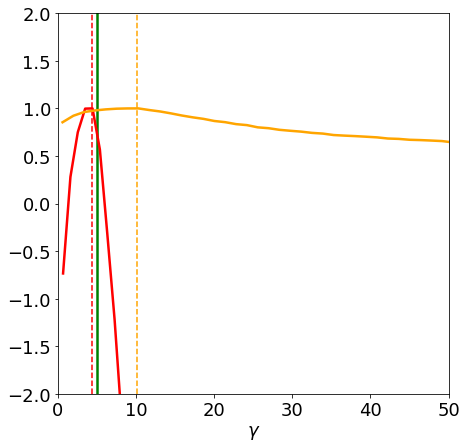

In [57]:
nBDs     = 1000; sigma= 0.1
f        = 1.; gamma = 1.3; rs = 5.

fig, axes = plt.subplots(1, 1, figsize=(7, 7))
     
    
axes.axvline(rs, color="g", ls="-", lw=2.5)
axes.set_xlabel(r"$\gamma$")


filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/fixedT10Tcut650/N%isigma0.1/" %nBDs)
_file    = open(filepath + ("like_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv13" %(nBDs, sigma, gamma, rs)), "rb") 
like     = pickle.load(_file)
filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/fixedT10Tcut650/N%isigma0.1/" %nBDs)
_file    = open(filepath + ("posterior_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv13" %(nBDs, sigma, gamma, rs)), "rb") 
samples  = pickle.load(_file)
bin_n=50
x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]
#print(x, y)
y = y - np.max(y[~np.isnan(y)]) + 1
#print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes.plot(x, y, ls="-", color="r", lw=2.5)
axes.axvline(samples[:, 2][np.argmax(like)], color="red", ls="--")
print(samples[:, 2][np.argmax(like)])


#kde   = gaussian_kde(samples.T[1])
#xvals = np.linspace(0., 2.8, 100)
#axes.plot(xvals, kde(xvals)/np.max(kde(xvals)), color="red", lw=2.5, ls=":")   

nBDs=100
filepath = ("/hdfs/local/mariacst/exoplanets/results/likelihood/velocity/v100/fixedT10Tcut650/N%isigma0.1/" %nBDs)
_file    = open(filepath + ("like_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv13" %(nBDs, sigma, gamma, rs)), "rb") 
like     = pickle.load(_file)
filepath = ("/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/fixedT10Tcut650/N%isigma0.1/" %nBDs)
_file    = open(filepath + ("posterior_fixedT10v100Tcut650_N%i_sigma%.1f_f1.0gamma%.1frs%.1fv13" %(nBDs, sigma, gamma, rs)), "rb") 
samples  = pickle.load(_file)
bin_n=50
x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]
#print(x, y)
y = y - np.max(y[~np.isnan(y)]) + 1
#print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes.plot(x, y, ls="-", color="orange", lw=2.5)
axes.axvline(samples[:, 2][np.argmax(like)], color="orange", ls="--")

#kde   = gaussian_kde(samples.T[1])
#xvals = np.linspace(0., 2.8, 100)
#axes.plot(xvals, kde(xvals)/np.max(kde(xvals)), color="orange", lw=2.5, ls=":")   

axes.set_ylim(-2, 2)
axes.set_xlim(0., 50)

### Reconstruction properties for different point estimates

In [9]:
imp.reload(utils_plots)
from utils_plots import FSE_f_gamma_rs, MSE_f_gamma_rs

rc('font',**{'family':'serif','serif':['Palatino'], 'size':18})

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


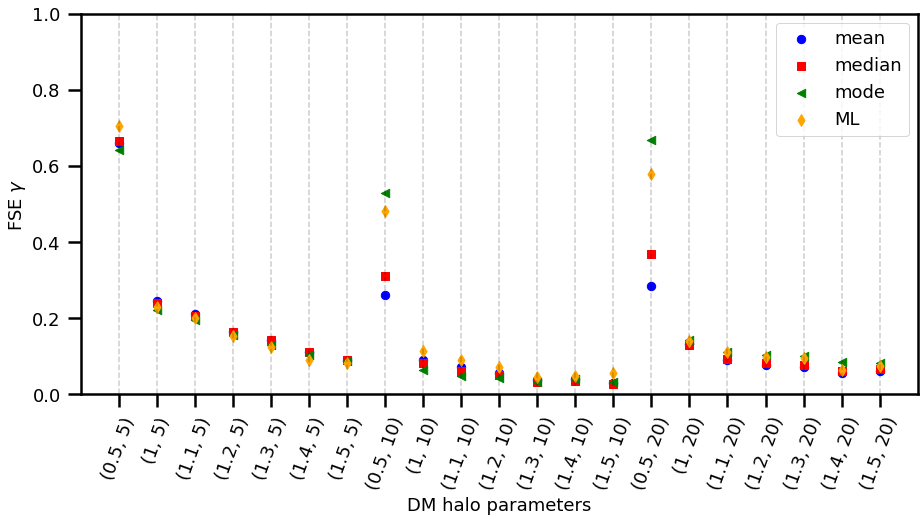

In [10]:
path = "/home/mariacst/exoplanets/results/velocity/v100/priorsRC/"
ex   = "priorsRC"
nBDs = 100
sigma = 0.1

gamma = [0.5, 1, 1.1, 1.2, 1.3, 1.4, 1.5]
rs    = [5, 10, 20]
x     = np.linspace(0, 1, 21)

PE     = ["mean", "median", "mode", "ML"]
color  = ["blue", "red", "green", "orange"]
marker = ["o", "s", "<", "d"]

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
i = 0
for pe in PE:
    xi, yi, _, zi_2, _ = FSE_f_gamma_rs(path, nBDs, sigma, ex, rank=100, PE=pe)
    
    ax.scatter(x, np.ravel(zi_2), color=color[i], marker=marker[i], label=pe, s=70.)
    i+=1
    
for i in x:
    ax.axvline(i, ls="--", alpha=0.2, color="k")

ax.legend()
ax.set_xticks(x)    
ax.set_xticklabels(['(0.5, 5)', '(1, 5)', '(1.1, 5)', '(1.2, 5)', '(1.3, 5)', 
                    '(1.4, 5)', '(1.5, 5)', '(0.5, 10)', '(1, 10)', '(1.1, 10)', '(1.2, 10)', 
                    '(1.3, 10)', '(1.4, 10)', '(1.5, 10)', '(0.5, 20)', '(1, 20)', '(1.1, 20)', 
                    '(1.2, 20)', '(1.3, 20)', '(1.4, 20)', '(1.5, 20)'], 
                   rotation=70);

ax.set_ylim(0, 1.)
ax.set_ylabel(r"FSE $\gamma$"); ax.set_xlabel("DM halo parameters")

for axis in ['top','bottom','left','right']:                                    
    ax.spines[axis].set_linewidth(2.5) 
ax.tick_params(which='major',direction="out",width=2.5,length=13,right=False,top=False,pad=7)
#fig.savefig(ex + "_FSE_gamma.png", bbox_inches="tight")

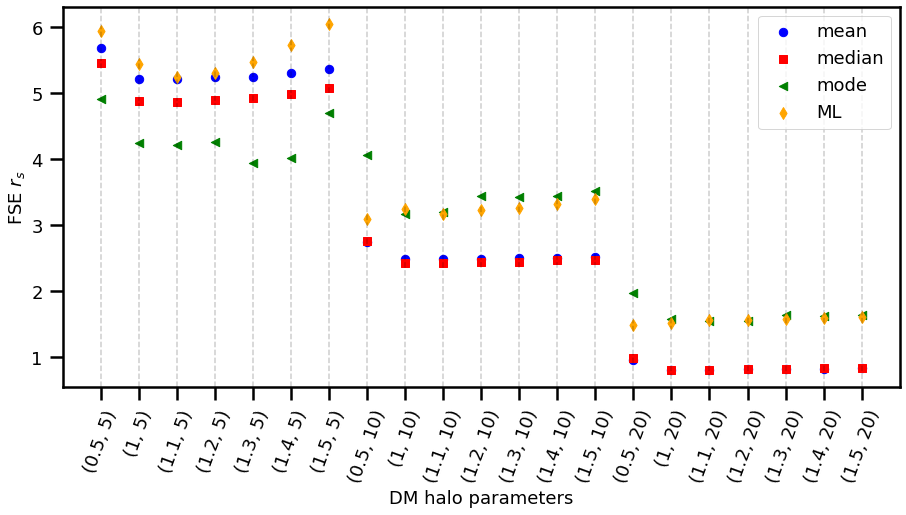

In [87]:
path = "/home/mariacst/exoplanets/results/velocity/v100/fixedT10v100/"
ex   = "fixedT10v100"
nBDs = 100
sigma = 0.1

gamma = [0.5, 1, 1.1, 1.2, 1.3, 1.4, 1.5]
rs    = [5, 10, 20]
x     = np.linspace(0, 1, 21)

PE     = ["mean", "median", "mode", "ML"]
color  = ["blue", "red", "green", "orange"]
marker = ["o", "s", "<", "d"]

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
i = 0
for pe in PE:
    xi, yi, _, _, zi_3 = FSE_f_gamma_rs(path, nBDs, sigma, ex, rank=100, PE=pe)
    
    ax.scatter(x, np.ravel(zi_3), color=color[i], marker=marker[i], label=pe, s=70.)
    i+=1
    
for i in x:
    ax.axvline(i, ls="--", alpha=0.2, color="k")

ax.legend()
ax.set_xticks(x)    
ax.set_xticklabels(['(0.5, 5)', '(1, 5)', '(1.1, 5)', '(1.2, 5)', '(1.3, 5)', 
                    '(1.4, 5)', '(1.5, 5)', '(0.5, 10)', '(1, 10)', '(1.1, 10)', '(1.2, 10)', 
                    '(1.3, 10)', '(1.4, 10)', '(1.5, 10)', '(0.5, 20)', '(1, 20)', '(1.1, 20)', 
                    '(1.2, 20)', '(1.3, 20)', '(1.4, 20)', '(1.5, 20)'], 
                   rotation=70);

#ax.set_ylim(0, 1.)
ax.set_ylabel(r"FSE $r_s$"); ax.set_xlabel("DM halo parameters")

for axis in ['top','bottom','left','right']:                                    
    ax.spines[axis].set_linewidth(2.5) 
ax.tick_params(which='major',direction="out",width=2.5,length=13,right=False,top=False,pad=7)
fig.savefig(ex + "_FSE_rs.pdf", bbox_inches="tight")

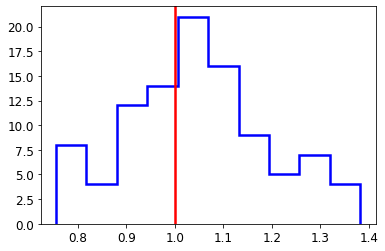

In [53]:
data = np.genfromtxt(path + "statistics_ex1_N100_sigma0.1_f1.0gamma%.1frs%.1f" %(1, 20), unpack=True)

pe = data[1]

fig, ax = plt.subplots()

ax.hist(pe, histtype="step", color="blue", lw=2.5);
ax.axvline(1., color="red", lw=2.5)

## HPD w/ pymc3 statistics

I get an error when running in terminal!

In [78]:
from pymc3.stats import hpd

In [96]:
filepath = "/hdfs/local/mariacst/exoplanets/results/posterior/velocity/v100/"
nBDs=100; rel_unc=0.1; f=1.; gamma=1.5; rs=20.

hpd_1sigma = []

for i in range(100):
    file_name  = (filepath + ("N%isigma%.1f/posterior_" %(nBDs, rel_unc))   
                 + ex +                                                        
                 ("_N%i_sigma%.1f_f%.1fgamma%.1frs%.1fv%i"                     
                 %(nBDs, rel_unc, f, gamma, rs, i+1)))                         
    samples    = pickle.load(open(file_name, "rb")) 
    hpd_1sigma.append(hpd(samples, alpha=0.32))
    
hpd_1sigma = np.array(hpd_1sigma)
print(hpd_1sigma.shape)

(100, 3, 2)


In [102]:
rank=99
print(hpd_1sigma[rank])
print(hpd_1sigma[rank][2, 1])

[[ 0.14358159  0.9648952 ]
 [ 1.42184592  1.81377713]
 [23.7474298  66.63239129]]
66.63239128846016


In [86]:
print(hpd_1sigma.shape)

(3, 100)


In [91]:
D=3;rank=100
hpd_1sigma = np.zeros((D, rank))
print(hpd(samples, alpha=0.32))
print(hpd(samples, alpha=0.32).shape)


array([[ 0.14358159,  0.9648952 ],
       [ 1.42184592,  1.81377713],
       [23.7474298 , 66.63239129]])